In [1]:
import os
import sys
import pickle
import warnings
import itertools 
import numpy as np
import pandas as pd
import pandas as pd
import scanpy as sc
import pyranges as pr
from pycisTopic.qc import *
import matplotlib.pyplot as plt
from pycisTopic.clust_vis import *
from pycisTopic.lda_models import *
from pycisTopic.diff_features import *
from pycisTopic.cistopic_class import *
from pycisTopic.topic_binarization import *
from pycisTopic.iterative_peak_calling import *
from sklearn.model_selection import train_test_split
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling


#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

_stderr = sys.stderr                                                         
null = open(os.devnull,'wb')

/home/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-02 15:18:19,462	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# **scATAC-seq preprocessing using pycisTopic**

Now we will preprocess the scATAC-seq side of the multiome data.

Most importantly we will:

1. generate pseudobulk ATAC-seq profiles per cell type/subclass and call peaks
2. merge these peaks into a consensus peak-set
3. do quality control on the scATAC-seq barcodes
4. run topic modeling to find sets of co-accessible regions and to impute chromatin accessibility resolving the issue of drop outs

For this we will use the python package [pycisTopic](https://pycistopic.readthedocs.io/en/latest/).


### **Data Prep Parameters**

Specify aditional information and importantly, the location of the ATAC fragments file, whihc is the main input into `pycisTopic`

In [2]:
save_prefix = 'seaad_mtg' # this takes the format '{StudyName}_{ThreeLetterAccronymForBrainRegion}'

load_cell_data = True           # whether to load cell type annotations or to use dataframe containing metadata along with filtered cell type barcode and sample information
load_pseudobulk_profiles = True # Whether to split and (or) merge fragments into cell type specific bed or bigwig files or just load ones already split and merged
stage = 'split_n_merge'
load_peaks = True              # whether to load dictionary already called peaks
run_consensus_peaks = False      # whether to generate a consensus peak set
run_qc = False
run_cistopic_sample_processing = False
load_cistopic_object = True
load_topic_models = True
use_mallet = True


exclude_cells = None
#                   ['L5 IT', 'L4 IT', 'L6 IT', 'L6 IT Car3', 'L5/6 NP', 'L6b', 'L6 CT', 'L5 ET', 
#                  'Pvalb', 'Sst', 'Lamp5 Lhx6', 'Vip', 'Lamp5', 'Sncg', 'Chandelier', 'Sst Chodl', 'Pax6',
#                  'Astrocyte', 
#                  'Microglia-PVM',
#                  'OPC',
#                  'Oligodendrocyte',
#                  'Endothelial',
#                  'VLMC']

include_cells = None

cell_type_column = 'Subclass' # 'Supertype (non-expanded)', 'Subclass'

subclass = {'seaad_mtg': {'excitatory': ['L5 IT', 'L2/3 IT', 'L4 IT', 'L6 IT', 'L6 IT Car3', 'L5/6 NP', 'L6b', 'L6 CT', 'L5 ET'],
                          'inhibitory': ['Pvalb', 'Sst', 'Lamp5 Lhx6', 'Vip', 'Lamp5', 'Sncg', 'Chandelier', 'Sst Chodl', 'Pax6'],
                          'astrocyte': ['Astrocyte'],
                          'microglia': ['Microglia-PVM'],
                          'opc': ['OPC'],
                          'oligodendrocyte': ['Oligodendrocyte'],
                          'endothelial': ['Endothelial'],
                           'vlmc': ['VLMC'],
                         },

            'seaad_pfc': {'excitatory': ['L5 IT', 'L2/3 IT', 'L4 IT', 'L6 IT', 'L6 IT Car3', 'L5/6 NP', 'L6b', 'L6 CT', 'L5 ET'],
                          'inhibitory': ['Pvalb', 'Sst', 'Lamp5 Lhx6', 'Vip', 'Lamp5', 'Sncg', 'Chandelier', 'Sst Chodl', 'Pax6'],
                          'astrocyte': ['Astrocyte'],
                          'microglia': ['Microglia-PVM'],
                          'opc': ['OPC'],
                          'oligodendrocyte': ['Oligodendrocyte'],
                          'endothelial': ['Endothelial'],
                           'vlmc': ['VLMC'],
                         },
            
            'gazestani_pfc': {'excitatory': ['FEZF2', 'RORB', 'THEMIS', 'LINC00507', 'CTGF'],
                              'inhibitory': ['PVALB', 'SST', 'LHX6', 'LAMP5', 'VIP', 'NDNF'],
                              'astrocyte': ['WIF1', 'CHI3L1', 'PTCSC3', 'GRIA1'],
                              'microgliverbosea': ['Myeloid', 'CX3CR1', 'GPNMB', 'Prolif', 'IRM', 'Macrophage', 'CRM'],
                              'opc': ['PBX3', 'ANKRD55', 'BRCA2', 'OPC', 'PLP1'],
                              'oligodendrocyte': ['GRIK2', 'BACE2', 'PLXDC2', 'SLC38A1'],
                              'endothelial': ['ABCC9', 'TMEM45B', 'GPR126', 'C7', 'HRK', 'IGFBP6', 'DOCK8', 'G0S2', 'APLN', 'COL8A1'],
                        }
            }

map_meta = True

get_cell_types = False   # whether to reformat cell_type annotation

subject_ids_for_study = {'leng_sfg': 'PatientID',
                        'leng_etc': 'PatientID',
                        'seaad_mtg': 'Donor ID', 
                        'seaad_pfc': 'Donor ID', 
                        'gazestani_pfc': 'individualID'}

subject_id = subject_ids_for_study[save_prefix]     # for leng this is `PatientID` for mathys is 'Subject', and allen is 'individualID'
metadata = f'../data/raw/{save_prefix}/{save_prefix}_metadata.csv' # Metatdata location
meta = pd.read_csv(metadata, encoding_errors='ignore')

region_name = save_prefix.split('_')[-1].upper()
save_dir = f'/media/tadeoye/Volume1/SEA-AD/{region_name}/ATACseq/results'
tmp_dir = f'/media/tadeoye/Volume1/SEA-AD/{region_name}/ATACseq/temp_files'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


fragments_dir = f'/media/tadeoye/Volume1/SEA-AD/{region_name}/ATACseq/fragments/'
fragments_dict = {fragment.split('-')[0]: fragments_dir + fragment for fragment in os.listdir(fragments_dir) if fragment.endswith('.tsv.gz')}
fragments_metadata = pd.read_csv(fragments_dir+f'{save_prefix}_fragments_metadata.csv')
fragments_metadata['fileID'] = fragments_metadata['fileID'].astype(str)

## **Generate pseudobulk ATAC-seq profiles, call peaks and generate a consensus peak set**

We will use the cell type labels from the scRNA-seq side of the data to generate pseudobulk profiles per cell type. These pseudobulk profiles will be used to call peaks which will be merged in one consensus peak set.

The advantage of calling peaks per cell type (instead of calling peaks on the whole bulk profile at once) is that, for rare cell types, there is a risk that the ATAC signal of these cells might be confused for noise by the peak caller when viewed in the whole bulk profile. Calling peaks per cell type helps resolving these rare peaks and thus increases the resolution of the data.

We will first load the cell type annotation in the scRNA-seq data

### **Get Cell Type Annotations**


In [3]:
if load_cell_data:
    # Read cell data from a CSV file
    cell_data = pd.read_csv(f'../data/raw/{save_prefix}/{save_prefix}_cell_data.csv', dtype=str)
    cell_data.set_index('cell_barcode', inplace=True)
    
    # Remove keys from fragments_dict if the corresponding sample_id is not present in cell_data
    for key in list(fragments_dict.keys()):
        if key not in cell_data['sample_id'].unique():
            del fragments_dict[key]
    
    # filter cell_data to include only the specified cell types
    if exclude_cells != None:
        cells_to_include = [ctype for ctype in list(itertools.chain(*list(subclass[save_prefix].values()))) if ctype not in exclude_cells]
        cell_data = cell_data[cell_data['celltype'].isin(cells_to_include)]
    
    if include_cells != None:
        cells_to_include = [ctype for ctype in list(itertools.chain(*list(subclass[save_prefix].values()))) if ctype in include_cells]
        cell_data = cell_data[cell_data['celltype'].isin(cells_to_include)] 

else:
    # Read cell data from an h5ad file
    adata = sc.read_h5ad('/media/tadeoye/Volume1/SEA-AD/MTG/ATACseq/anndata/SEAAD_MTG_ATACseq_final-nuclei.2024-02-13.h5ad')
    # adata = sc.read_h5ad('/media/tadeoye/Volume1/SEA-AD/MTG/ATACseq/anndata/SEAAD_MTG_ATACseq_all-nuclei.2024-02-13.h5ad')
    cell_data = adata.obs.copy()
    del (adata)
    
    # Filter cell data based on 
    cell_data = cell_data[cell_data['Neurotypical reference'] == 'False']
    cell_data = cell_data[cell_data['Severely Affected Donor'] == 'N']
    cell_data = cell_data[~cell_data['sample_id'].isna()]
    
    cell_data['celltype'] = cell_data[cell_type_column]
    cell_data = cell_data[~cell_data['celltype'].isna()]
    
    cell_data['cell_barcode'] = cell_data['sample_id'].apply(lambda x: "-".join([x.split('-')[0], '1']))
    cell_data['sample_id'] = cell_data['sample_id'].apply(lambda x: x.split('-')[-1]).astype(str)
    cell_data['cell_barcode'] = cell_data['cell_barcode'] + '.' + cell_data['sample_id']
     
    # Filter cell data to include only the files present in both cell_data and fragments_metadata
    files = list(set(cell_data['sample_id'].unique()) & set(fragments_metadata['fileID'].unique()))
    cell_data = cell_data[cell_data['sample_id'].isin(files)]
    cell_data.set_index('cell_barcode', inplace=True)
    
    # split the cell type into 2 if the number of cells is greater than 60000, 
    for cell_type in cell_data.celltype.unique():   
        X = cell_data[cell_data['celltype']==cell_type]
        y = X['Donor ID']
        
        if len(y) > 60000:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True, stratify=y)   

            cell_data['celltype'] = cell_data['celltype'].cat.add_categories([cell_type+'_1', cell_type+'_2'])
            cell_data.loc[X_train.index, 'celltype'] = cell_type+'_1'
            cell_data.loc[X_test.index, 'celltype'] = cell_type+'_2'

    # Remove keys from fragments_dict if the corresponding sample_id is not present in cell_data
    for key in list(fragments_dict.keys()):
        if key not in cell_data['sample_id'].unique():
            del fragments_dict[key]
    
    # Save the processed cell data to a CSV file
    cell_data.to_csv(f'../data/raw/{save_prefix}/{save_prefix}_cell_data.csv')
    
    # filter cell_data to include only the specified cell types
    if exclude_cells != None:
        cells_to_include = [ctype for ctype in list(itertools.chain(*list(subclass[save_prefix].values()))) if ctype not in exclude_cells]
        cell_data = cell_data[cell_data['celltype'].isin(cells_to_include)]
    
    if include_cells != None:
        cells_to_include = [ctype for ctype in list(itertools.chain(*list(subclass[save_prefix].values()))) if ctype in include_cells]
        cell_data = cell_data[cell_data['celltype'].isin(cells_to_include)]

In [4]:
print(f'Total number of cells: {len(cell_data)}')

cell_data['celltype'].value_counts()

Total number of cells: 380825


L2/3 IT_2          57059
L2/3 IT_1          57058
L4 IT              46441
L5 IT              33886
Vip                29563
Pvalb              28923
Oligodendrocyte    24409
Sst                19904
L6 IT              13376
Lamp5              11457
Astrocyte          10457
L6 IT Car3          6979
Sncg                6492
Microglia-PVM       6032
OPC                 5420
Lamp5 Lhx6          5386
L5/6 NP             4816
L6 CT               3689
L6b                 3422
Pax6                2297
Chandelier          1741
VLMC                 766
L5 ET                735
Sst Chodl            325
Endothelial          192
Name: celltype, dtype: int64

### **Get Chromosome Sizes**

In [5]:
# Get chromosome sizes (for hg38 here)
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]

# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

### **Generate Pseudobulk Profile**

Next, we will generate the pseudobulk profiles. 

This will generate two sets of files:

1. pseudobulk_bed_files: pseudobulk profiles stored in [bed format](https://genome.ucsc.edu/FAQ/FAQformat.html).
2. pseudobulk_bw_files: pseudobulk profiles stored in [BigWig format](https://genome.ucsc.edu/goldenpath/help/bigWig.html).

The BigWig files are useful for visualization in [IGV](https://software.broadinstitute.org/software/igv/) or [UCSC genome browser](https://genome.ucsc.edu/).

This function will generate a `fragments.tsv.gz` and a `bigwig` file for each cell type defined by the `variable` parameter. 

For each cell type:

- The `fragments.tsv.gz` contains all fragments for barcodes of that cell type.
- A `bigwig` file will be generated for each `fragments.tsv.gz` file, this we can visualize in any genome browser.

In [6]:
if load_pseudobulk_profiles:
    
    print(f"loading bigwig and bed files in {os.path.join(save_dir, 'consensus_peak_calling/')}")
    

    bed_paths = pickle.load(open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
    bw_paths =  pickle.load(open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'rb'))

else:
    bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                                            variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                                            sample_id_col = 'sample_id',
                                            chromsizes = chromsizes,
                                            bed_path = os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                                            bigwig_path = os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bw_files/'), # specify where pseudobulk_bw_files should be stored
                                            path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                                            n_cpu = 20,                                                                                 # specify the number of cores to use, we use ray for multi processing
                                            normalize_bigwig = True,
                                            #remove_duplicates = True,
                                            temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                                            split_pattern = '.',
                                            stage = stage,
                                            verbose = True)
        
    for key in list(bed_paths.keys()):
        bed_paths[key.replace(' ', '_').replace('/', '_')] = bed_paths[key]
        del bed_paths[key]
        bw_paths[key.replace(' ', '_').replace('/', '_')] = bw_paths[key]
        del bw_paths[key]

    
    bed_paths_saved = pickle.load(open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
    bw_paths_saved =  pickle.load(open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'rb'))
   
    bed_paths.update(bed_paths_saved)
    bw_paths.update(bw_paths_saved)
    
    pickle.dump(bed_paths, 
            open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
    pickle.dump(bw_paths,
            open(os.path.join(save_dir, 'consensus_peak_calling/pseudobulk_bw_files/bw_paths.pkl'), 'wb'))

loading bigwig and bed files in /media/tadeoye/Volume1/SEA-AD/MTG/ATACseq/results/consensus_peak_calling/


### **Call peaks per pseudobulk profile**

Next we will use [MACS](https://github.com/macs3-project/MACS) to call peaks for each pseudobulk `fragments.tsv.gz` file.

In [7]:
macs_path='~/miniconda3/envs/scenicplus/bin/macs2'
tmp_dir = f'/media/tadeoye/Volume1/temp_files'


if load_peaks:

    print(f"loading peaks in {os.path.join(save_dir, 'consensus_peak_calling/MACS/')}")
    narrow_peaks_dict = pickle.load(open(os.path.join(save_dir, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'rb'))
    
else:
    # Run peak calling
    narrow_peaks_dict = peak_calling(macs_path,
                                    bed_paths,
                                    os.path.join(save_dir, 'consensus_peak_calling/MACS/'),
                                    genome_size='hs',
                                    n_cpu=20,
                                    input_format='BEDPE',
                                    shift=73, 
                                    ext_size=146,
                                    keep_dup = 'all',
                                    q_value = 0.05,
                                    _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
    pickle.dump(narrow_peaks_dict, 
            open(os.path.join(save_dir, 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

loading peaks in /media/tadeoye/Volume1/SEA-AD/MTG/ATACseq/results/consensus_peak_calling/MACS/


### **Merge peaks into consensus peak set**

Finally, it is time to derive the consensus peaks. To do so, we use the `TGCA iterative peak filtering approach`. 
First, each summit is extended a `peak_half_width` in each direction and then we iteratively filter out less 
significant peaks that overlap with a more significant one. During this procedure peaks will be merged and depending 
on the number of peaks included into them, different processes will happen:

- `1 peak`: The original peak region will be kept

- `2 peaks`: The original peak region with the highest score will be kept

- `3 or more peaks`: The orignal peak region with the most significant score will be taken, and all the original peak regions in this merged peak region that overlap with the significant peak region will be removed. The process is repeated with the next most significant peak (if it was not removed already) until all peaks are processed.

This proccess will happen twice, first for each pseudobulk peaks; and after peak score normalization, to process all peaks together.

for more info see [pyCistopic read the docs](https://pycistopic.readthedocs.io/en/latest/features.html).

In [8]:
if run_consensus_peaks:
    # Other param
    peak_half_width = 250
    path_to_blacklist= '../scripts/functions/pycisTopic/blacklist/hg38-blacklist.v2.bed'

    # Get consensus peaks
    consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

    consensus_peaks.to_bed(
                    path = os.path.join(save_dir, 'consensus_peak_calling/consensus_regions.bed'), 
                    keep=True, 
                    compression='infer', 
                    chain=False)

## **Quality control**

Next we will calculate sample level and cell-barcode level quality control statistics.

#### **Sample level statistics**

1. **Barcode rank plot:** The barcode rank plot `shows the distribution of non-duplicate reads and which barcodes were inferred to be associated with cells`. A steep drop-off (‘knee’) is indicative of good separation between the cell-associated barcodes and the barcodes associated with empty partitions.

2. **Insertion size:** `The nucleosome signal refers to the ratio of mono-nucleosomal to nucloesome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell`. ATAC-seq requires a proper pair of Tn5 transposase cutting events at the ends of DNA. In the nucleosome-free open chromatin regions, many molecules of Tn5 can kick in and chop the DNA into small pieces; around nucleosome-occupied regions, and Tn5 can only access the linker regions. Therefore, in a good ATAC-seq library, you should expect to see a sharp peak at the <100 bp region (open chromatin), and a peak at ~200bp region (mono-nucleosome), and other larger peaks (multi-nucleosomes). `A clear nucleosome pattern indicates a good quality of the experiment`.

3. **Sample TSS enrichment:** `The TSS enrichment calculation is a signal to noise calculation`. The reads around a reference set of TSSs are collected to form an aggregate distribution of reads centered on the TSSs and extending to 1000 bp in either direction (for a total of 2000bp). This distribution is then normalized by taking the average read depth in the 100 bps at each of the end flanks of the distribution (for a total of 200bp of averaged data) and calculating a fold change at each position over that average read depth. This means that the flanks should start at 1, and if there is high read signal at transcription start sites (highly open regions of the genome) there should be an increase in signal up to a peak in the middle.

4. **Duplication rate per cell barcode.** A fragment is considered “usable” if it uniquely maps to the genome and remains after removing PCR duplicates (defined as two fragments that map to the same genomic position and have the same unique molecular identifier). `The duplication rate serves to estimate the amount of usable reads per barcode`. High duplication rates may indicate over-sequencing or lack of fragments after transposition and encapsulation.


#### **Barcode level QC stats**

These stats will be used to filter good quality cell barcodes from bad quality ones:


1. **Log number of unique fragments per cell barcode:** Total number of fragments per cell representing cellular sequencing depth. This metric is analogous to the number of total counts in scRNA-seq data.

2. **TSS enrichment per cell barcode:** Transcription start site (TSS) enrichment score, which is the ratio of fragments centered at the TSS to fragments in TSS-flanking regions. This metric can be interpreted as a signal-to noise ratio of each cell. The score at position in the TSS enrichment score for each barcode (at position 0, the TSS). `Noisy cells will have a low TSS enrichment`.

3. **Fraction of Reads In Peaks (FRIP) per cell barcode:** The fraction of fragments in peak regions versus fragments outside of peaks. Similar to the TSS score, this is an indicator for the signal-to-noise ratio. The fraction of reads in peaks for each barcode. `Noisy cells have low FRIP values`. However, this filter should be used with nuance, as it depends on the quality of the original peaks. For example, if there is a rare population in the sample, its specific peaks may be missed by peak calling algorithms, causing a decrease in their FRIP values.

4. **Number of features per cell:** The number of peaks with non-zero counts in each cell. This metric is analogous to the number of genes detected in scRNA-seq data.

5. **Nucleosome Signal:** The nucleosome signal refers to the ratio of mono-nucleosomal to nucloesome-free fragments and can also be interpreted as a signal-to-noise ratio in each cell (more details below).



To calculate the TSS enrichment we need to provide TSS annotations. We can easily download them via the `pycistopic tss get_tss` command.

In [9]:
if run_qc:
    
    os.makedirs(f"{save_dir}/qc", exist_ok=True)

    # Run the pycistopic tss command
    os.system(f"pycistopic tss get_tss "
            f"--output {save_dir}/qc/tss.bed "
            f"--name hsapiens_gene_ensembl "
            f"--to-chrom-source ucsc "
            f"--ucsc hg38")

In [10]:
if run_qc:
    
    result = subprocess.run(["head", f"{save_dir}/qc/tss.bed"], stdout=subprocess.PIPE)
    output = result.stdout.decode("utf-8")
    formatted_output = subprocess.run(["column", "-t"], input=output, encoding="utf-8", stdout=subprocess.PIPE, text=True).stdout

    print(formatted_output)

Next, we calculate the QC metrics using the `pycistopic qc` command.

In [11]:
if run_qc:
    
    regions_bed_filename = os.path.join(save_dir, "consensus_peak_calling/consensus_regions.bed")
    tss_bed_filename = os.path.join(save_dir, "qc", "tss.bed")

    pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

    # Create text file with all pycistopic qc command lines.
    with open(pycistopic_qc_commands_filename, "w", encoding="utf-8") as fh:
        for sample, fragment_filename in fragments_dict.items():
            command = [
                        "pycistopic",
                        "qc",
                        "--fragments", fragment_filename,
                        "--regions", regions_bed_filename,
                        "--tss", tss_bed_filename,
                        "--output", os.path.join(save_dir, "qc", sample)
                    ]
            fh.write(" ".join(command) + "\n")

Run the following in a command line environment.

In [12]:
if run_qc:
    os.system(f"cat {pycistopic_qc_commands_filename} | parallel -j 20 {{}}")

#### **Vizualize Sample level statistics**

Finally, we can visualize sample level statistics.


These include:

- **Barcode rank plot**

- **Insertion size**

- **Sample TSS enrichment**

/home/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/plotting/qc_plot.py:226: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


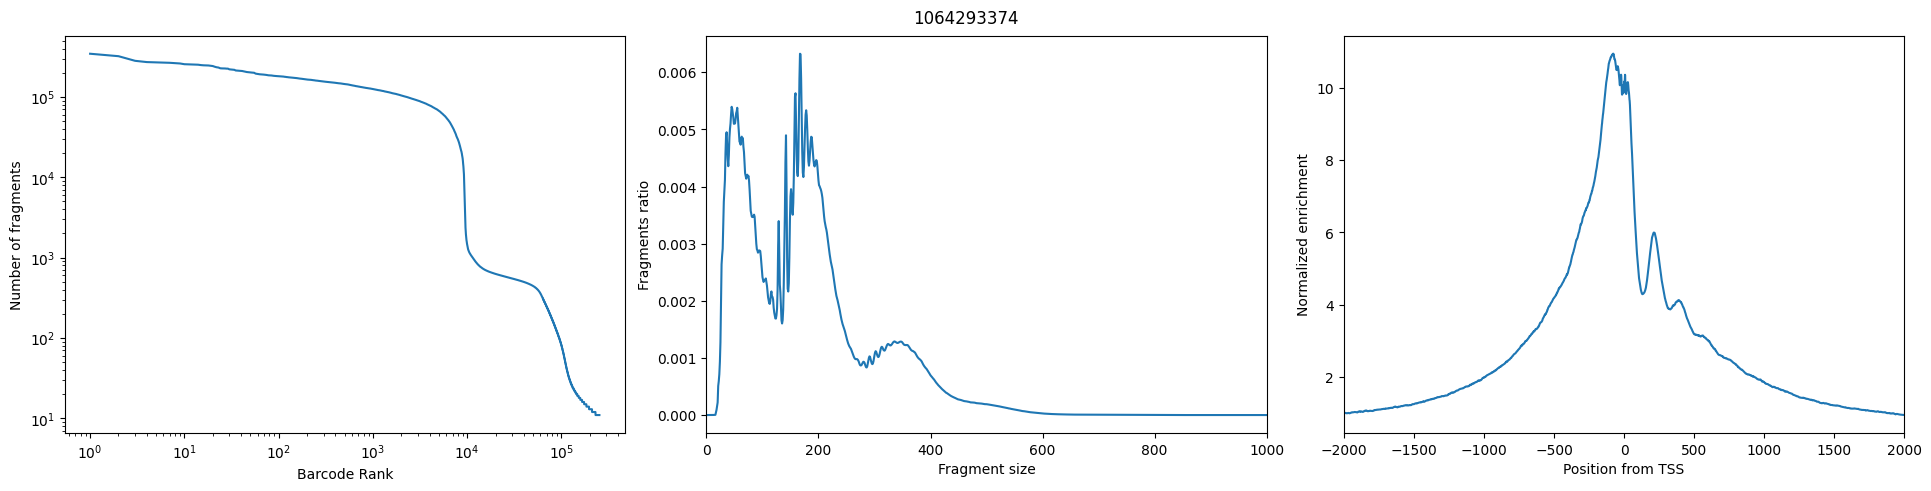

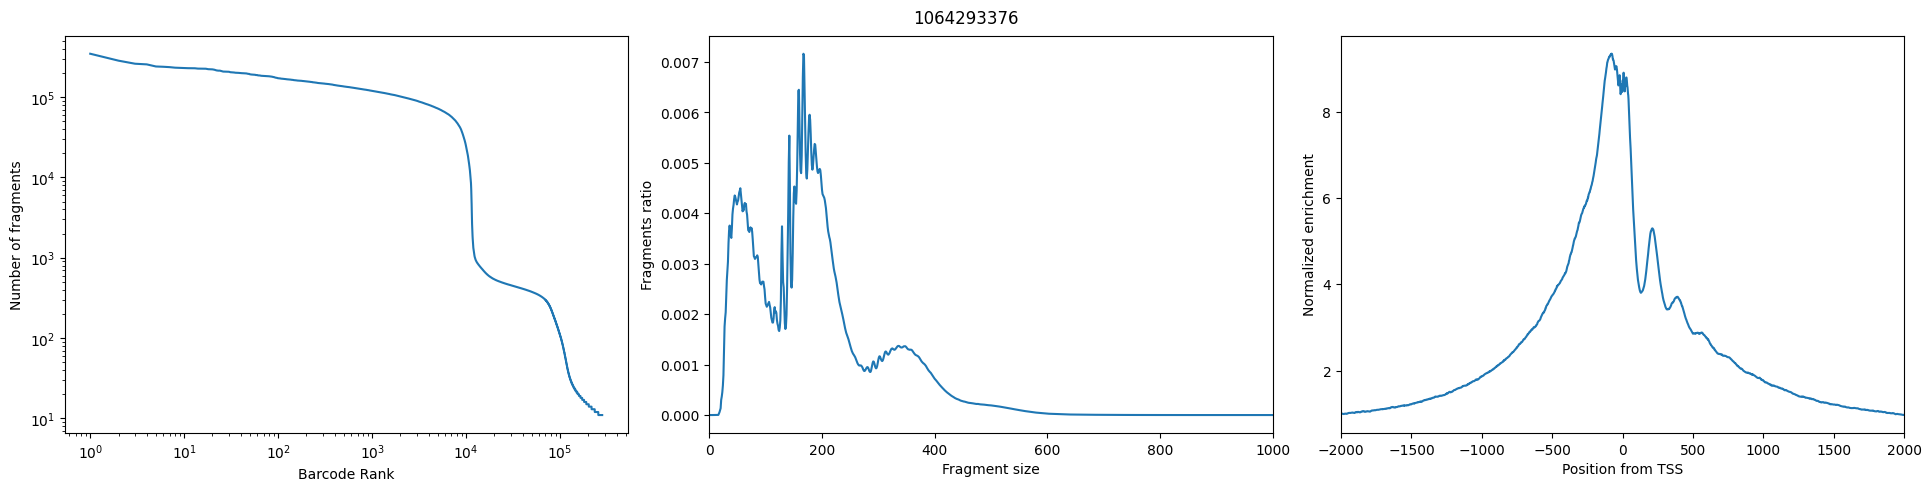

In [13]:
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
# for convenience, vizualize just two samples
for sample_id in ['1064293374', '1064293376']:
    fig = plot_sample_stats(
                            sample_id = sample_id,
                            pycistopic_qc_output_dir = os.path.join(save_dir, "qc")
                            )

#### **Vizualize Barcode level statistics**

We can also visualize barcode level statistics.

These statistics can be used to filter cell barcodes to retain only high quality cells.

<div class="alert alert-info">

**Note:**

The `pycistopic qc` command will determine automatic thresholds for the minimum number of unique number of fragments and the minumum TSS enrichment.
In case you want to change these thresholds or want to threhold based on FRIP, you can provide manually defined thresholds using the parameters:
- unique_fragments_threshold
- tss_enrichment_threshold
- frip_threshold
    
In this case we use the automatically defined thresholds
    
</div>


The barcode level statistics include:

- **Total number of (unique) fragments**

- **TSS enrichment**

- **FRIP**

In [14]:
if run_qc:
    
    from pycisTopic.qc import get_barcodes_passing_qc_for_sample
    sample_id_to_barcodes_passing_filters = {}
    sample_id_to_thresholds = {}
    for sample_id in fragments_dict:

        (sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]) = get_barcodes_passing_qc_for_sample(
                                                                                sample_id = sample_id,
                                                                                pycistopic_qc_output_dir = os.path.join(save_dir, "qc"),
                                                                                unique_fragments_threshold = None, # use automatic thresholding
                                                                                tss_enrichment_threshold = None, # use automatic thresholding
                                                                                frip_threshold = 0,
                                                                                use_automatic_thresholds = True,
                                                                                )
    pickle.dump(sample_id_to_barcodes_passing_filters, 
            open(os.path.join(save_dir, 'qc/sample_id_to_barcodes_passing_filters.pkl'), 'wb'))
    pickle.dump(sample_id_to_thresholds,
            open(os.path.join(save_dir, 'qc/sample_id_to_thresholds.pkl'), 'wb'))
    
else:
    sample_id_to_barcodes_passing_filters = pickle.load(open(os.path.join(save_dir, 'qc/sample_id_to_barcodes_passing_filters.pkl'), 'rb'))
    sample_id_to_thresholds =  pickle.load(open(os.path.join(save_dir, 'qc/sample_id_to_thresholds.pkl'), 'rb'))
   


/home/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/plotting/qc_plot.py:446: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


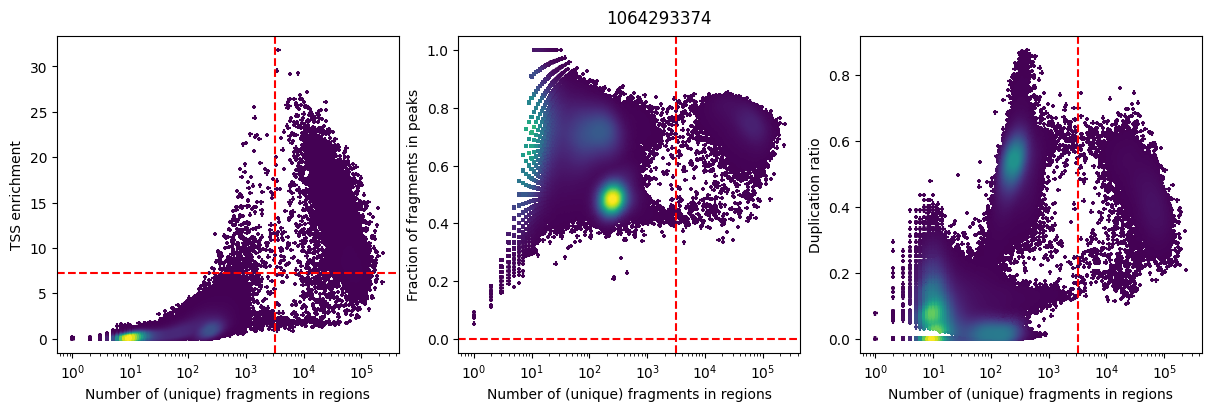

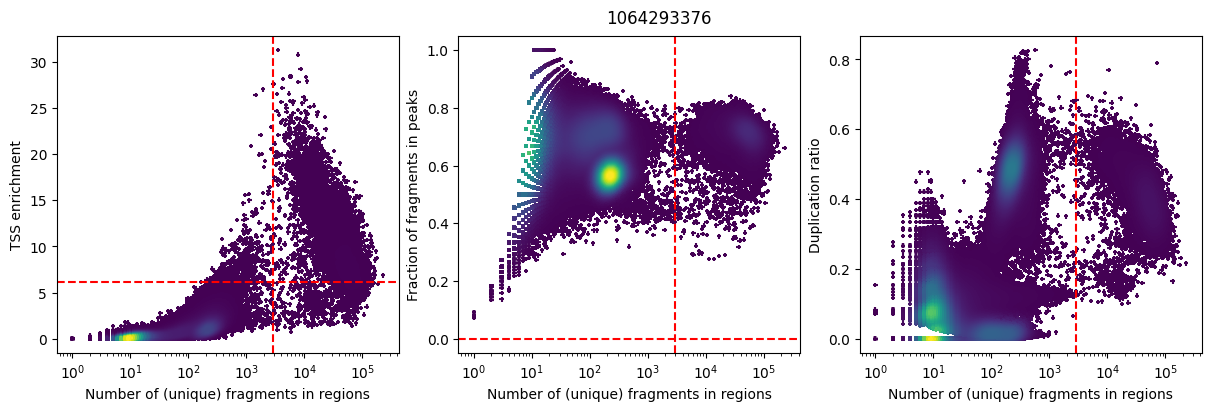

In [15]:
for sample_id in ['1064293374', '1064293376']:
    fig = plot_barcode_stats(
                            sample_id = sample_id,
                            pycistopic_qc_output_dir = os.path.join(save_dir, "qc"),
                            bc_passing_filters = sample_id_to_barcodes_passing_filters[sample_id],
                            detailed_title = False,
                            **sample_id_to_thresholds[sample_id]
                            )

## **Creating a cisTopic object**

Now that we have good quality barcodes we will generate a binary count matrix of ATAC-seq fragments over consensus peaks. This matrix, along with metadata, will be stored in a cisTopic object and be used for topic modeling.

For SCENIC+ we will only keep cells which passed quality metrics in the scATA-seq assay. Also, **[Blacklist regions](https://www.nature.com/articles/s41598-019-45839-z)** will be removed from this count matrix.

Create cisTopic object

In [16]:
path_to_regions = os.path.join(save_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist= '../scripts/functions/pycisTopic/blacklist/hg38-blacklist.v2.bed'
pycistopic_qc_output_dir = os.path.join(save_dir, "qc")

os.makedirs(f"{save_dir}/cistopic_objects", exist_ok=True)

from pycisTopic.cistopic_class import parallel_cistopic_processing

if run_cistopic_sample_processing:

    parallel_cistopic_processing(
                            fragments_dict = fragments_dict,
                            pycistopic_qc_output_dir = pycistopic_qc_output_dir,
                            sample_id_to_barcodes_passing_filters = sample_id_to_barcodes_passing_filters,
                            cell_data = cell_data,
                            path_to_regions = path_to_regions,
                            path_to_blacklist = path_to_blacklist,
                            save_dir = save_dir,
                            n_jobs = 8,
                            use_partition = False
                            )

if load_cistopic_object:

    print('Loading cistopic object!')
    
    atac = sc.read_h5ad(os.path.join(save_dir, 'cistopic_objects/all_sample_cistopic_anndata.h5ad'))
    
    cistopic_obj = create_cistopic_object(fragment_matrix=atac.layers['counts'].T.astype(int),
                                    cell_names=atac.obs_names.to_list(),
                                    region_names=atac.var_names.to_list(),
                                    tag_cells=False
                                    )
    cistopic_obj.add_cell_data(atac.obs)   

    del atac

else:

    cistopic_obj_list = []
    for sample_id in fragments_dict:
        cistopic_obj_list.append(pickle.load(open(os.path.join(save_dir, f'cistopic_objects/{sample_id}_cistopic.pkl'), 'rb')))

    del cistopic_obj_list
        
    cistopic_obj = merge(cistopic_obj_list, split_pattern='.')

    cistopic_metadata = cistopic_obj.cell_data.copy()
    cistopic_metadata = cistopic_metadata.merge(cell_data, how='left', left_index=True, right_index=True)

    cistopic_metadata = cistopic_metadata.drop(columns=[col for col in cistopic_metadata.columns if col.endswith("_y")])
    cistopic_metadata = cistopic_metadata.rename(columns={col: col[:-2] for col in cistopic_metadata.columns if col.endswith("_x")})

    cistopic_metadata = cistopic_metadata.loc[:, ~cistopic_metadata.columns.duplicated(keep='first')]

    cistopic_obj.add_cell_data(cistopic_metadata)

    pickle.dump(cistopic_obj, open(os.path.join(save_dir, 'cistopic_objects/all_sample_cistopic.pkl'), 'wb')) 

    del cistopic_metadata
    
    adata = sc.AnnData(cistopic_obj.binary_matrix.T)
    adata.layers['counts'] = cistopic_obj.fragment_matrix.T
    adata.obs = cistopic_obj.cell_data
    adata.var = cistopic_obj.region_data

    atac = sc.read_h5ad('/media/tadeoye/Volume1/SEA-AD/MTG/ATACseq/anndata/SEAAD_MTG_ATACseq_final-nuclei.2024-02-13.h5ad')

    atac.obs['cell_barcode'] = atac.obs['sample_id'].apply(lambda x: "-".join([x.split('-')[0], '1']))
    atac.obs['sample_id'] = atac.obs['sample_id'].apply(lambda x: x.split('-')[-1]).astype(str)
    atac.obs['cell_barcode'] = atac.obs['cell_barcode'] + '.' + atac.obs['sample_id']
    atac.obs.set_index('cell_barcode', inplace=True)
    atac = atac[adata.obs.index]

    adata.uns = atac.uns.copy()
    adata.obsm = atac.obsm.copy()
    adata.obsp = atac.obsp.copy()

    del atac

    for col in list(adata.obs.columns):
        if adata.obs[col].dtype=='O':
            if pd.isna(adata.obs[col][0]):
                adata.obs[col] = adata.obs[col].astype('category')
            elif adata.obs[col][0].dtype in ['int64', 'int32', 'float32', 'float64']:
                adata.obs[col] = adata.obs[col].astype(float)
            else:
                adata.obs[col] = adata.obs[col].astype('category')

    adata.write_h5ad(os.path.join(save_dir, 'cistopic_objects/all_sample_cistopic_anndata.h5ad'), compression='gzip')   

    del adata


Loading cistopic object!
2024-08-02 15:32:09,460 cisTopic     INFO     Creating CistopicObject
2024-08-02 15:52:26,913 cisTopic     INFO     Done!
Columns ['cisTopic_nr_acc', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_log_nr_acc', 'sample_id'] will be overwritten


## **Topic modeling**

Next we will perform the actual topic modeling using LDA using a Collapsed Gibbs Sampler.

There are two functions that can be used to perform the topic modeling, both producde similar results.

- **Serial LDA**: The parallelization is done between models rather than within each model. Recommended for small-medium sized data sets in which several models with different number of topics are being tested. You can run these models with `run_cgs_models()`.
- **Parallel LDA with MALLET**: The parallelization is done within each model. Recommended for large data sets where a few models with different number of topics are being tested. If working in a cluster, we recommed to submit a job per model so they can run simultaneously. You can run it with `run_cgs_modela_mallet()`.

Here, we will use Mallet.

<div class="alert alert-info">

**Note:**

In order to be able to run Mallet you need the Mallet binary, these binaries can be downloaded from [Github](https://github.com/mimno/Mallet/releases).
You can also compile the binary from source, for more information please visit the [Mallet Github repository](https://github.com/mimno/Mallet).
    
</div>



The purpose of this is twofold:

1. To find `sets of co-accessible regions (topics)`, this will be used downstream as candidate enhancers (together with `Differentially Accessible Regions (DARs`).
2. To impute dropouts. 

<div class="alert alert-info">

**Note:**

scATAC-seq data is *very* sparse. This is because of the nature of the technique. It profiles chromatin accessibility in single cells and each cell only has two copies (two alleles) of each genomic region, also the genome is realtively large (so the number of regions which can be measured is large). `For this reason drop outs are a *real* problem`, the chance of measuring a specific genomic region (out of *many* potential regions) which only has two copies per cell is relatively small. Compare this to scRNA-seq analysis, here the number of genes which can be measure is relatively small (compared to the number of genomic regions) and each cell has potentially hundres of copies of each transcript. `To account for drop outs in the scATAC-seq assay imputation techniques are often used, in this case we make use of topic modeling`, making use of the fact that the data often contains cells which are quite similar to each other but might have slightly different features measured. 
</div>


Before running the topic modeling we are not sure what the best number of topics will be to explain the data. Analog to PCA where you also often don't know before hand what the best number of principle components is. For this reason we will generate models with increasing numbers of topics and after the fact choose the model with the optimal amount of topics. For demonstration purposes we will only try a few amount of models, you might want to explore a larger number of topics.

<div class="alert alert-warning">

**Warning:**

Topic modeling can be computationaly intense!
</div>

In [17]:
if use_mallet:
    target_dir = os.path.join(os.getcwd(), 'functions')
    mallet_file = os.path.join(target_dir, 'Mallet-202108', 'bin', 'mallet')
    if not os.path.exists(mallet_file):
        os.chdir(target_dir)
        os.system('wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz')       
        os.system('tar -xf Mallet-202108-bin.tar.gz')
        os.chdir('../')

Because we don't know yet what number of topics will be optimal for our dataset we will run several topic models, each with a different number of topics.

In [18]:
os.makedirs(os.path.join(save_dir, f'models'), exist_ok=True)

if load_topic_models:
    print('Loading Topic Models...')
    files = os.listdir(os.path.join(save_dir, f'models'))
    models = {}

    for file in files:
        if file.endswith('.pkl'):
            models[file.strip('.pkl')] = pickle.load(open(os.path.join(os.path.join(save_dir, f'models'), file), 'rb'))
    
else:

    if use_mallet:

        from pycisTopic.lda_models import run_cgs_models_mallet

        mallet_path=os.path.join(os.getcwd(), "functions/Mallet-202108/bin/mallet")

        os.makedirs(os.path.join(tmp_dir, 'ray_spill', 'mallet'), exist_ok=True)
        os.environ['MALLET_MEMORY'] = '200G'

        os.environ.update({'MALLET_HOME': r'/home/tadeoye/Documents/research_codes/cell_cell_communication/scripts/functions/Mallet-202108/'})


        models=run_cgs_models_mallet(
                                    cistopic_obj,
                                    n_topics=[2, 4, 10, 16, 24, 32, 48],
                                    n_cpu=40,
                                    n_iter=500,
                                    random_state=555,
                                    alpha=50,
                                    alpha_by_topic=True,
                                    eta=0.1,
                                    eta_by_topic=False,
                                    tmp_path=os.path.join(tmp_dir, 'ray_spill', 'mallet'),
                                    save_path=os.path.join(save_dir, f'models'),
                                    mallet_path=mallet_path,
                                    reuse_corpus=False,
                                    run_models_in_parallel=False
                                )    
    else:
        from pycisTopic.lda_models import run_cgs_models

        models=run_cgs_models(cistopic_obj,
                            n_topics=[2, 4, 10, 16, 24, 32, 48],
                            n_cpu=40,
                            n_iter=500,
                            random_state=555,
                            alpha=50,
                            alpha_by_topic=True,
                            eta=0.1,
                            eta_by_topic=False,
                            save_path=os.path.join(save_dir, f'models'),
                        )

Loading Topic Models...


### **Analyze models**

here is no optimal way to do this selection, however getting the exact optimal number of topics is also not critical.

We will make use of four quality metrics to select the model with the optimal amount of topics:

1. **Latent Dirichlet Allocation**
    - Uses a density-based metric as in [Arun *et al.* 2010](http://link.springer.com/10.1007/978-3-642-13657-3_43) using the topic-region distribution, the cell-topic distribution and the cell coverage. The better the model, the lower the metric.
2. **Density-based method for adaptive LDA model selection**
    - Uses a divergence-based metric as in [Cao & Juan *et al.* 2009](https://linkinghub.elsevier.com/retrieve/pii/S092523120800372X) using the topic-region distribution. The better the model, the lower the metric.
3. **Semantic Coherence [Mimno *et al.* 2011](http://dirichlet.net/pdf/mimno11optimizing.pdf)**
    - Uses the average model coherence as calculated by Mimno et al (2011). To reduce the impact of the number of topics, the average coherence based on the top selected average values is calculated. The better the model, the higher coherence.
4. **Log likelihood**
    - Uses the log-likelihood in the last iteration as calculated by Griffiths and Steyvers (2004), as used in cisTopic. The better the model, the higher the log-likelihood.

For more information on these metrics see publications (linked above) and the [read the docs](https://pycistopic.readthedocs.io/en/latest/) page of pycisTopic.

<div class="alert alert-info">

**Note:**

Note that for both the Arun and Cao metric a lower score is related to a better model, for visualization purposes we inverted these scores. 
In the plots below a higher score for these metrics are thus related to a better model.
    
Also note that not all metrics agree (see for example the Arun metric).

</div>

For scATAC-seq data models, the most helpful methods are Minmo (topic coherence) and the log-likelihood in the last iteration.

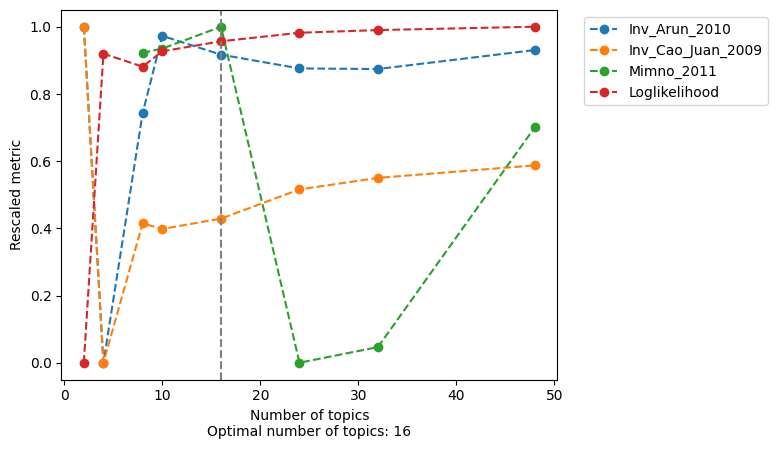

In [19]:
os.makedirs(os.path.join(save_dir, 'figures', 'model_evaluation'), exist_ok=True)

model = evaluate_models(list(models.values()),
                       select_model=16, 
                       return_model=True, 
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False,
                       save=os.path.join(save_dir, 'figures', 'model_evaluation', 'model_eval.pdf'))

The metrics seem to stabelise with a model using 16 topics, so let's choose that model. 

In [20]:
cistopic_obj.add_LDA_model(model)

## **Clustering and visualization**

We can cluster the cells (or regions) using the leiden algorithm, and perform dimensionality reductiion with UMAP and TSNE. Here, we use the cell-topic probabilities to generate dimensionality reductions.

In [21]:
from pycisTopic.clust_vis import (
                                find_clusters,
                                run_umap,
                                run_tsne,
                                plot_metadata,
                                plot_topic,
                                cell_topic_heatmap
                            )

In [22]:
find_clusters(
            cistopic_obj,
            target  = 'cell',
            k = 10,
            res = [0.6, 1.2, 3],
            prefix = 'pycisTopic_',
            scale = True,
            split_pattern = '-'
        )

run_umap(cistopic_obj, target  = 'cell', scale=True)

run_tsne(cistopic_obj, target  = 'cell', scale=True)

2024-08-02 15:52:35,205 cisTopic     INFO     Finding neighbours
2024-08-02 15:55:38,215 cisTopic     INFO     Running UMAP


/home/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2024-08-02 16:05:07,715 cisTopic     INFO     Running TSNE


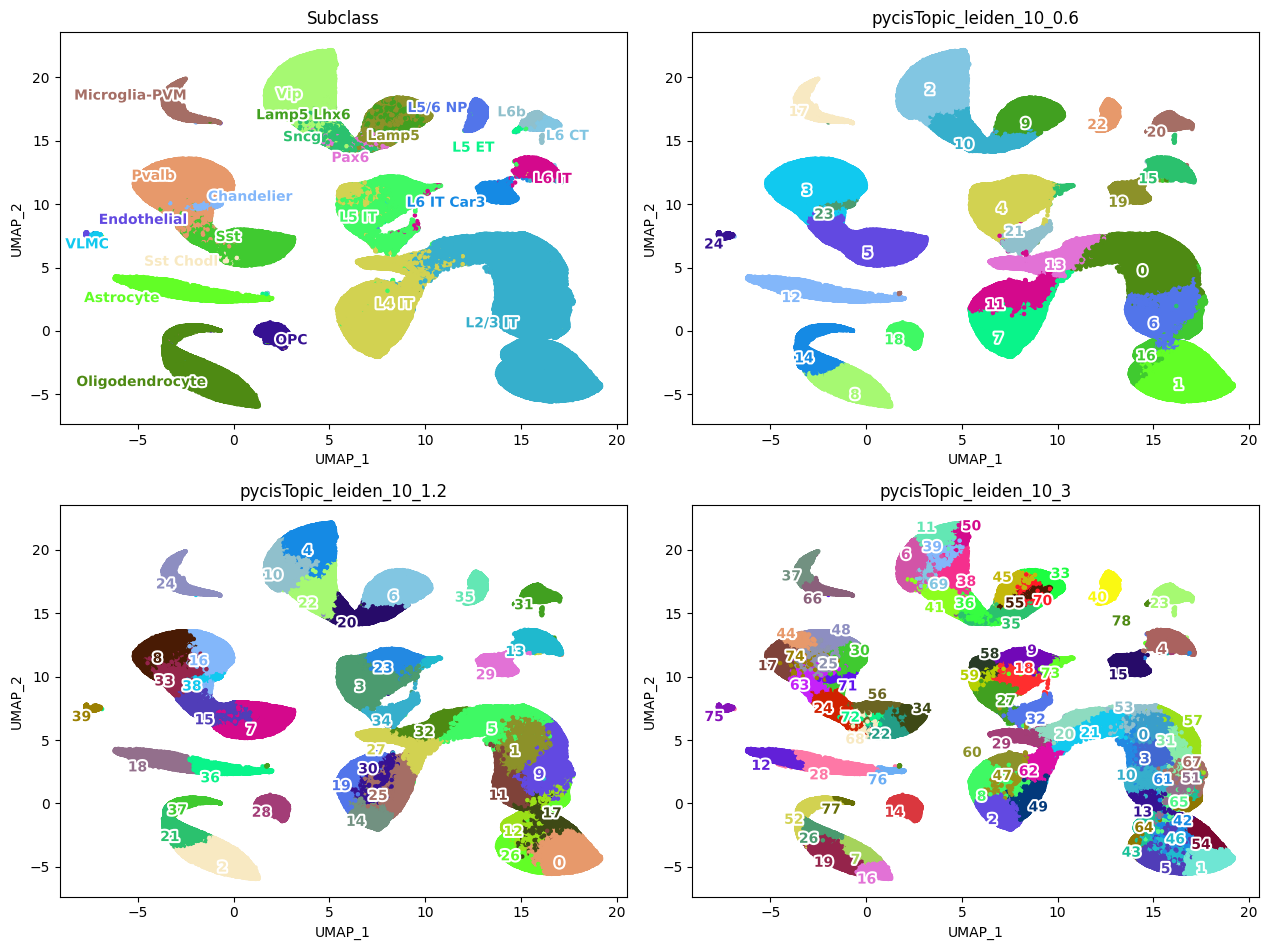

In [23]:
os.makedirs(os.path.join(save_dir, 'figures', 'umaps'), exist_ok=True)

plot_metadata(
            cistopic_obj,
            reduction_name='UMAP',
            variables=[cell_type_column, 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'], 
            target='cell', num_columns=2,
            text_size=10,
            dot_size=5,
            save=os.path.join(save_dir, 'figures', 'umaps', 'umap_and_topic_clustering.pdf')
        )

We annotate each cluster based on the overlap with scRNA-seq annotations.

In [24]:
annot_dict = {}
for resolution in [0.6, 1.2, 3]:
    annot_dict[f"pycisTopic_leiden_10_{resolution}"] = {}
    for cluster in set(cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"]):
        counts = cistopic_obj.cell_data.loc[
            cistopic_obj.cell_data.loc[cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"] == cluster].index, 
            cell_type_column].value_counts()
        annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"{counts.index[counts.argmax()]}({cluster})"

for resolution in [0.6, 1.2, 3]:
    cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'] = [
        annot_dict[f'pycisTopic_leiden_10_{resolution}'][x] for x in cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'].tolist()
    ]

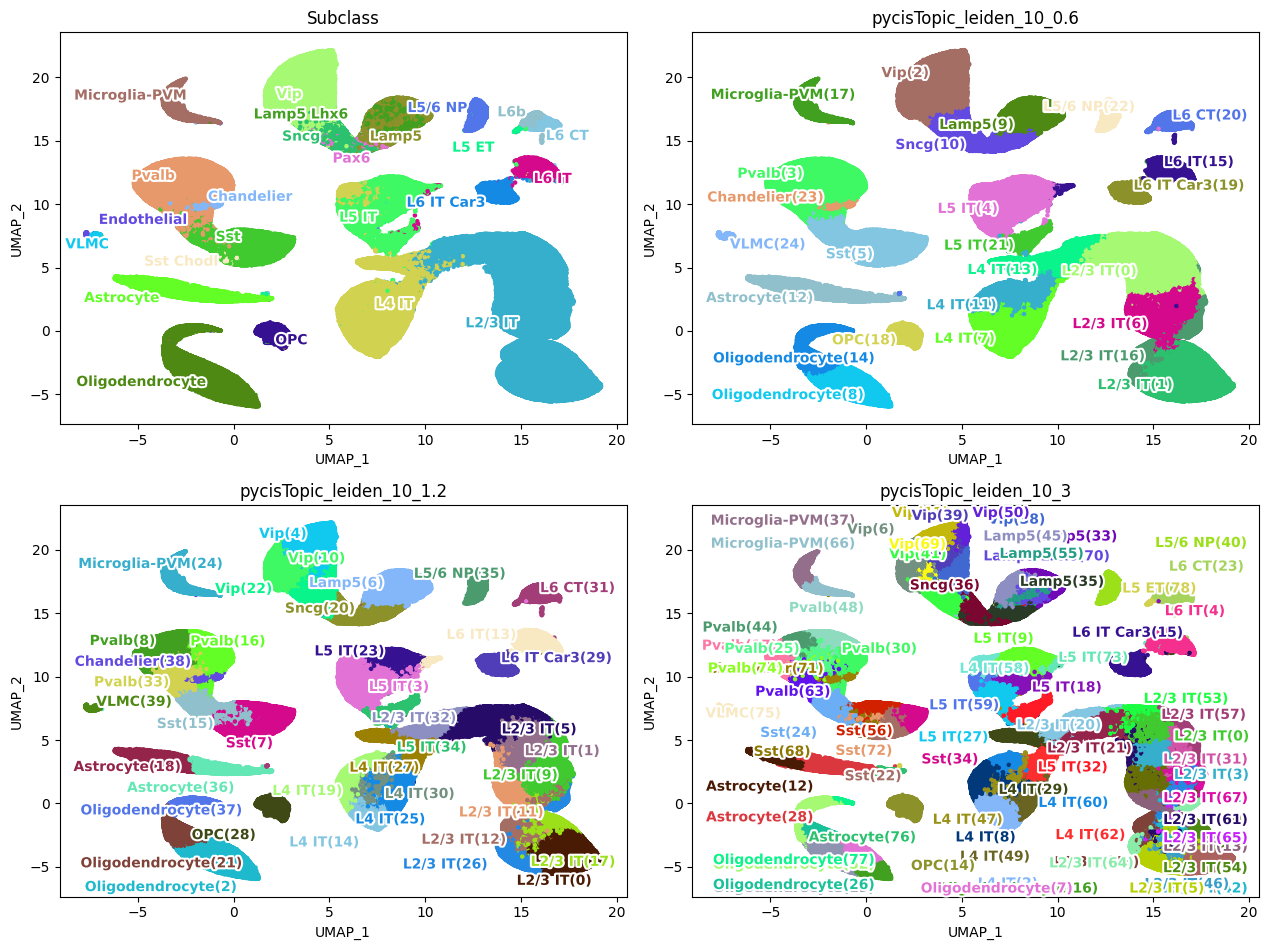

In [25]:
plot_metadata(
            cistopic_obj,
            reduction_name='UMAP',
            variables=[cell_type_column, 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'], 
            target='cell', num_columns=2,
            text_size=10,
            dot_size=5
        )

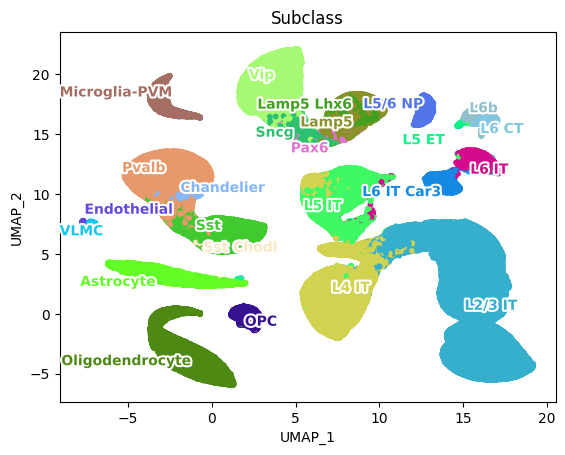

In [26]:
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = [cell_type_column],
              save = os.path.join(save_dir, 'figures', 'umaps', f'umap_{cell_type_column.lower()}.pdf'))

### **Cell-Topic Distributions**

We can also plot the cell-topic probabilities/distributions on the UMAP, to visualize their cell type specifiticy.

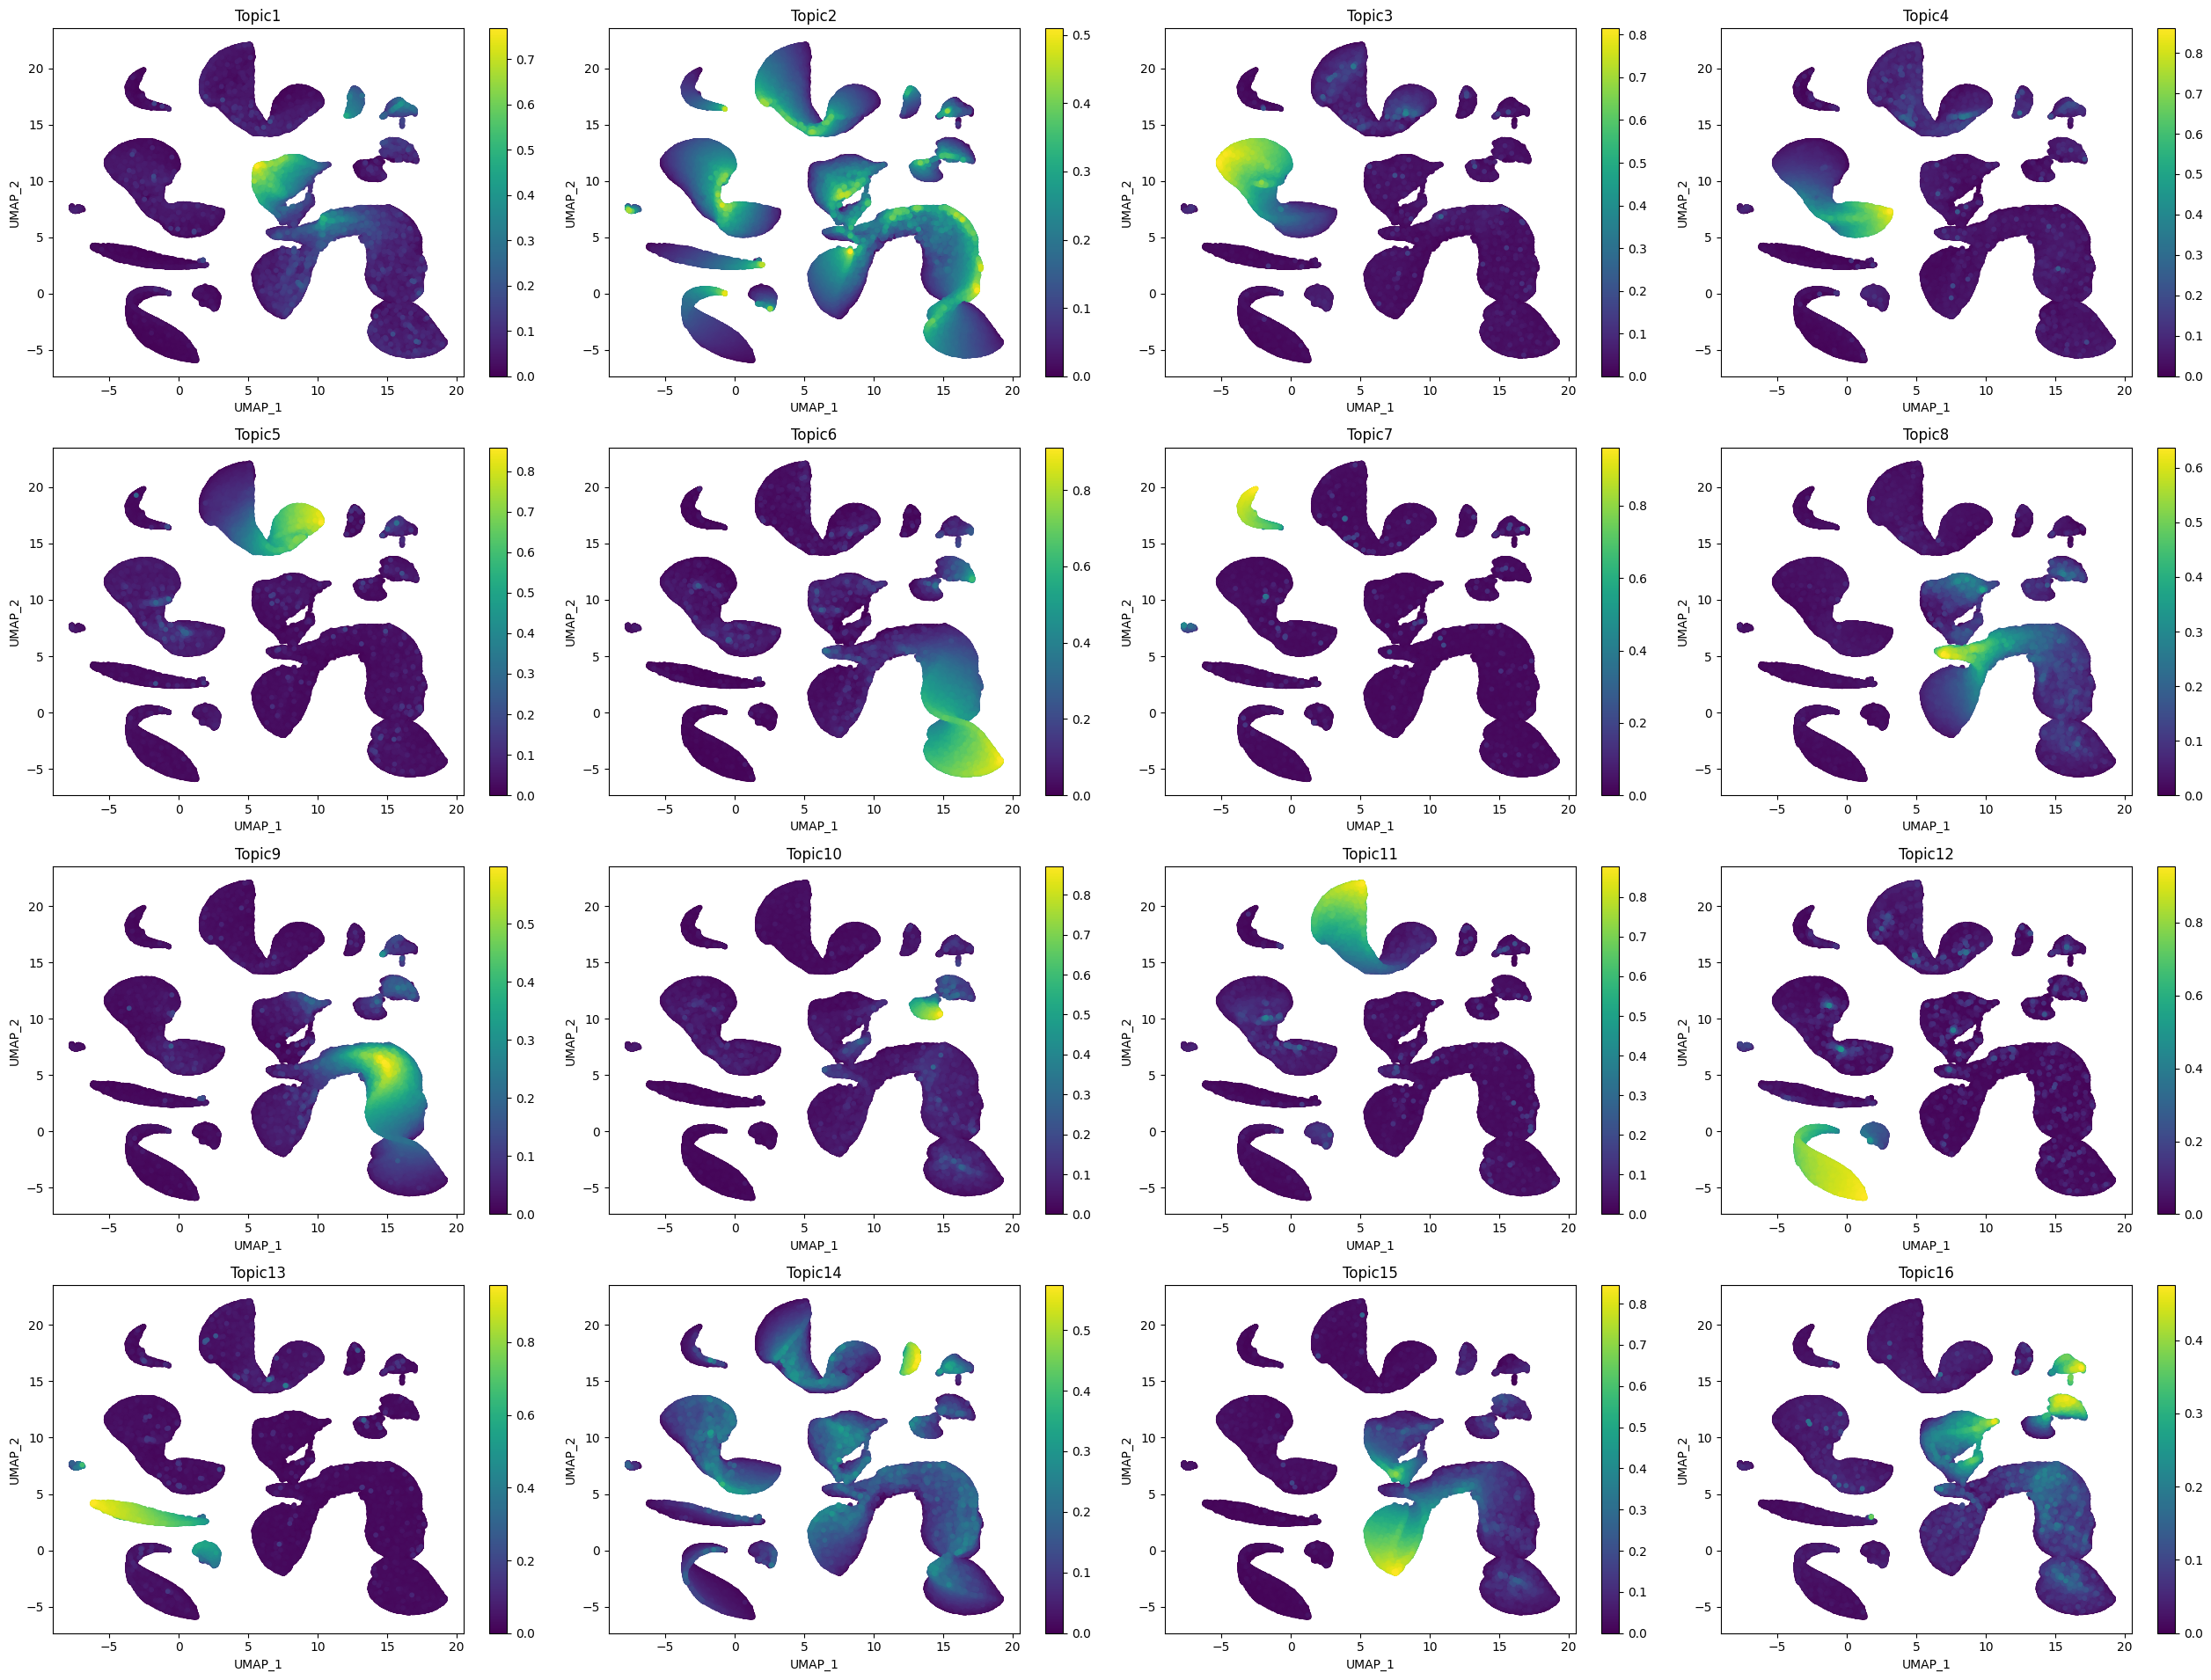

In [27]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4, 
           save = os.path.join(save_dir, 'figures', 'umaps', 'umap_topic_expression.pdf'))

Or we can also draw a heatmap with the topic contributions (and annotations).

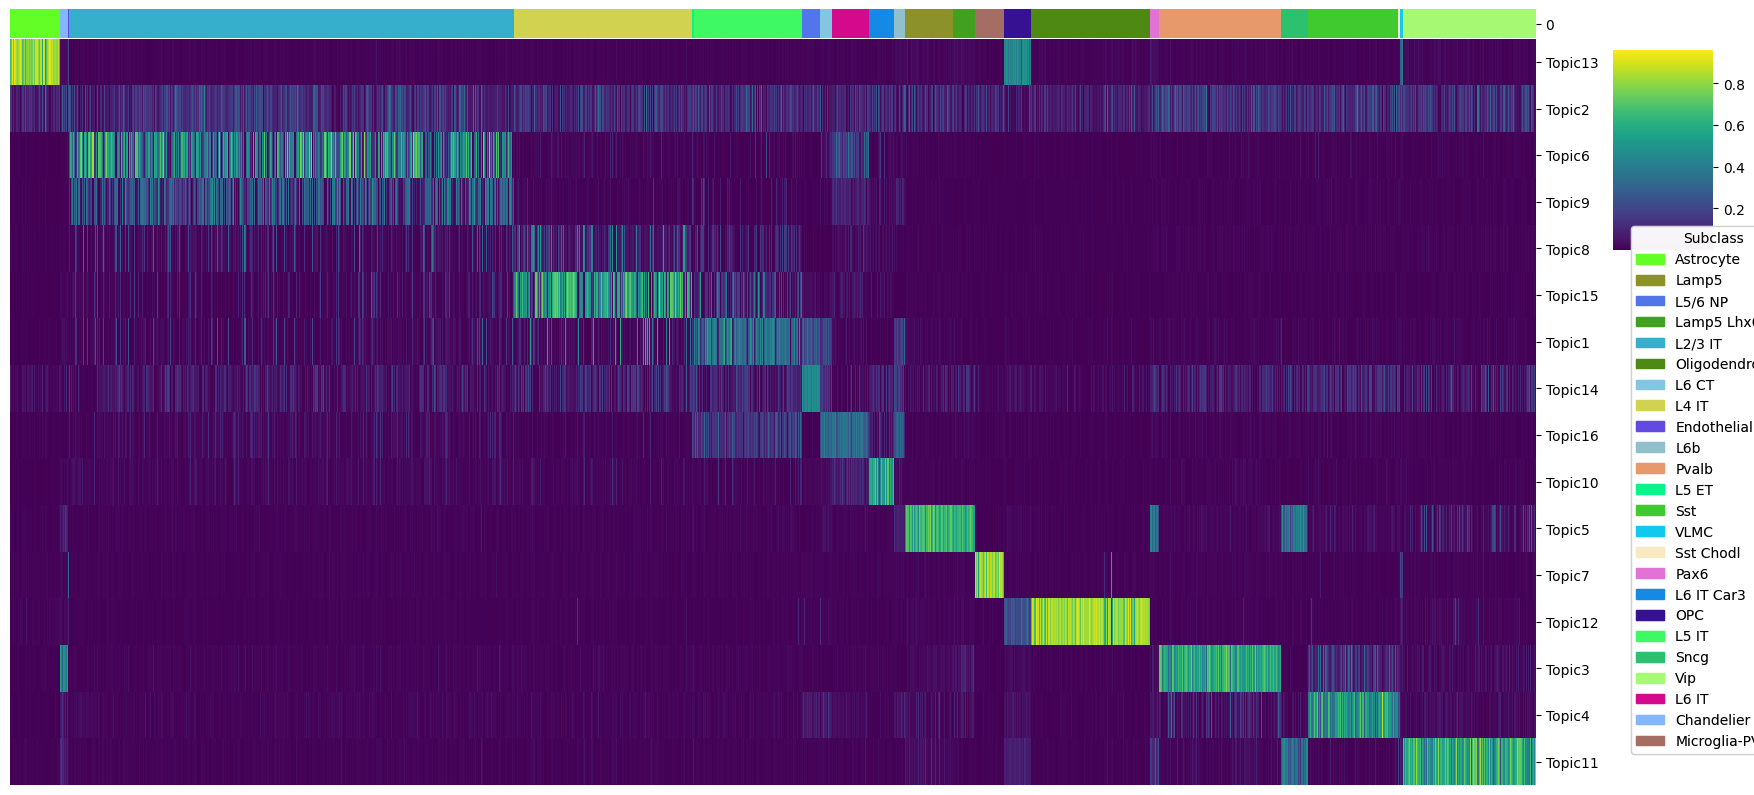

In [28]:
os.makedirs(os.path.join(save_dir, 'figures', 'heatmaps'), exist_ok=True)

cell_topic_heatmap(
                cistopic_obj,
                variables = [cell_type_column],
                scale = False,
                legend_loc_x = 1.0,
                legend_loc_y = -1.2,
                legend_dist_y = -10,
                figsize = (20, 10),
                color_dictionary = {},
                save = os.path.join(save_dir, 'figures', 'heatmaps', f'heatmap_topic_expression_per_{cell_type_column}.pdf')
            )

For further analysis see the [pycisTopic read the docs page](https://pycistopic.readthedocs.io/en/latest/)

## **Inferring Candidate Enhancer Regions Using Topic Binarization**

Next we will infer candidate enhancer regions by:

1. **binarization of region-topic probabilites/distributions.** 

    - This useful for exploring the topics with other tools that work with region sets (e.g. `GREAT`, `cisTarget`). There are several methods that can be used for this: **`otsu`** [Otsu, 1979](https://ieeexplore.ieee.org/document/4310076), **`yen`** [Yen et al., 1995](https://ieeexplore.ieee.org/document/366472), **`li`** [Li & Lee, 1993](https://www.sciencedirect.com/science/article/pii/003132039390115D), **`aucell`** [Van de Sande et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32561888/) or **`ntop`** (Taking the top n regions per topic). **`Otsu`** and **`Yen`**’s methods work well for topic-region distributions; however for some downstream analyses (e.g. deep learning) it may be convenient to use **`ntop`** to have balanced region sets.

2. **binarization of cell-topic distributions, which is useful to automatically annotate topics.**

3. **calculation differentially accessibile regions (DARs) per cell type/class.**

These regions will be used as input for the next step, [pycistarget](https://pycistarget.readthedocs.io/en/latest/), in which we will look which motifs are enriched in these regions.

First we will binarize the topics using the [otsu](http://ieeexplore.ieee.org/document/4310076/) method and by taking the top 3k regions per topic.

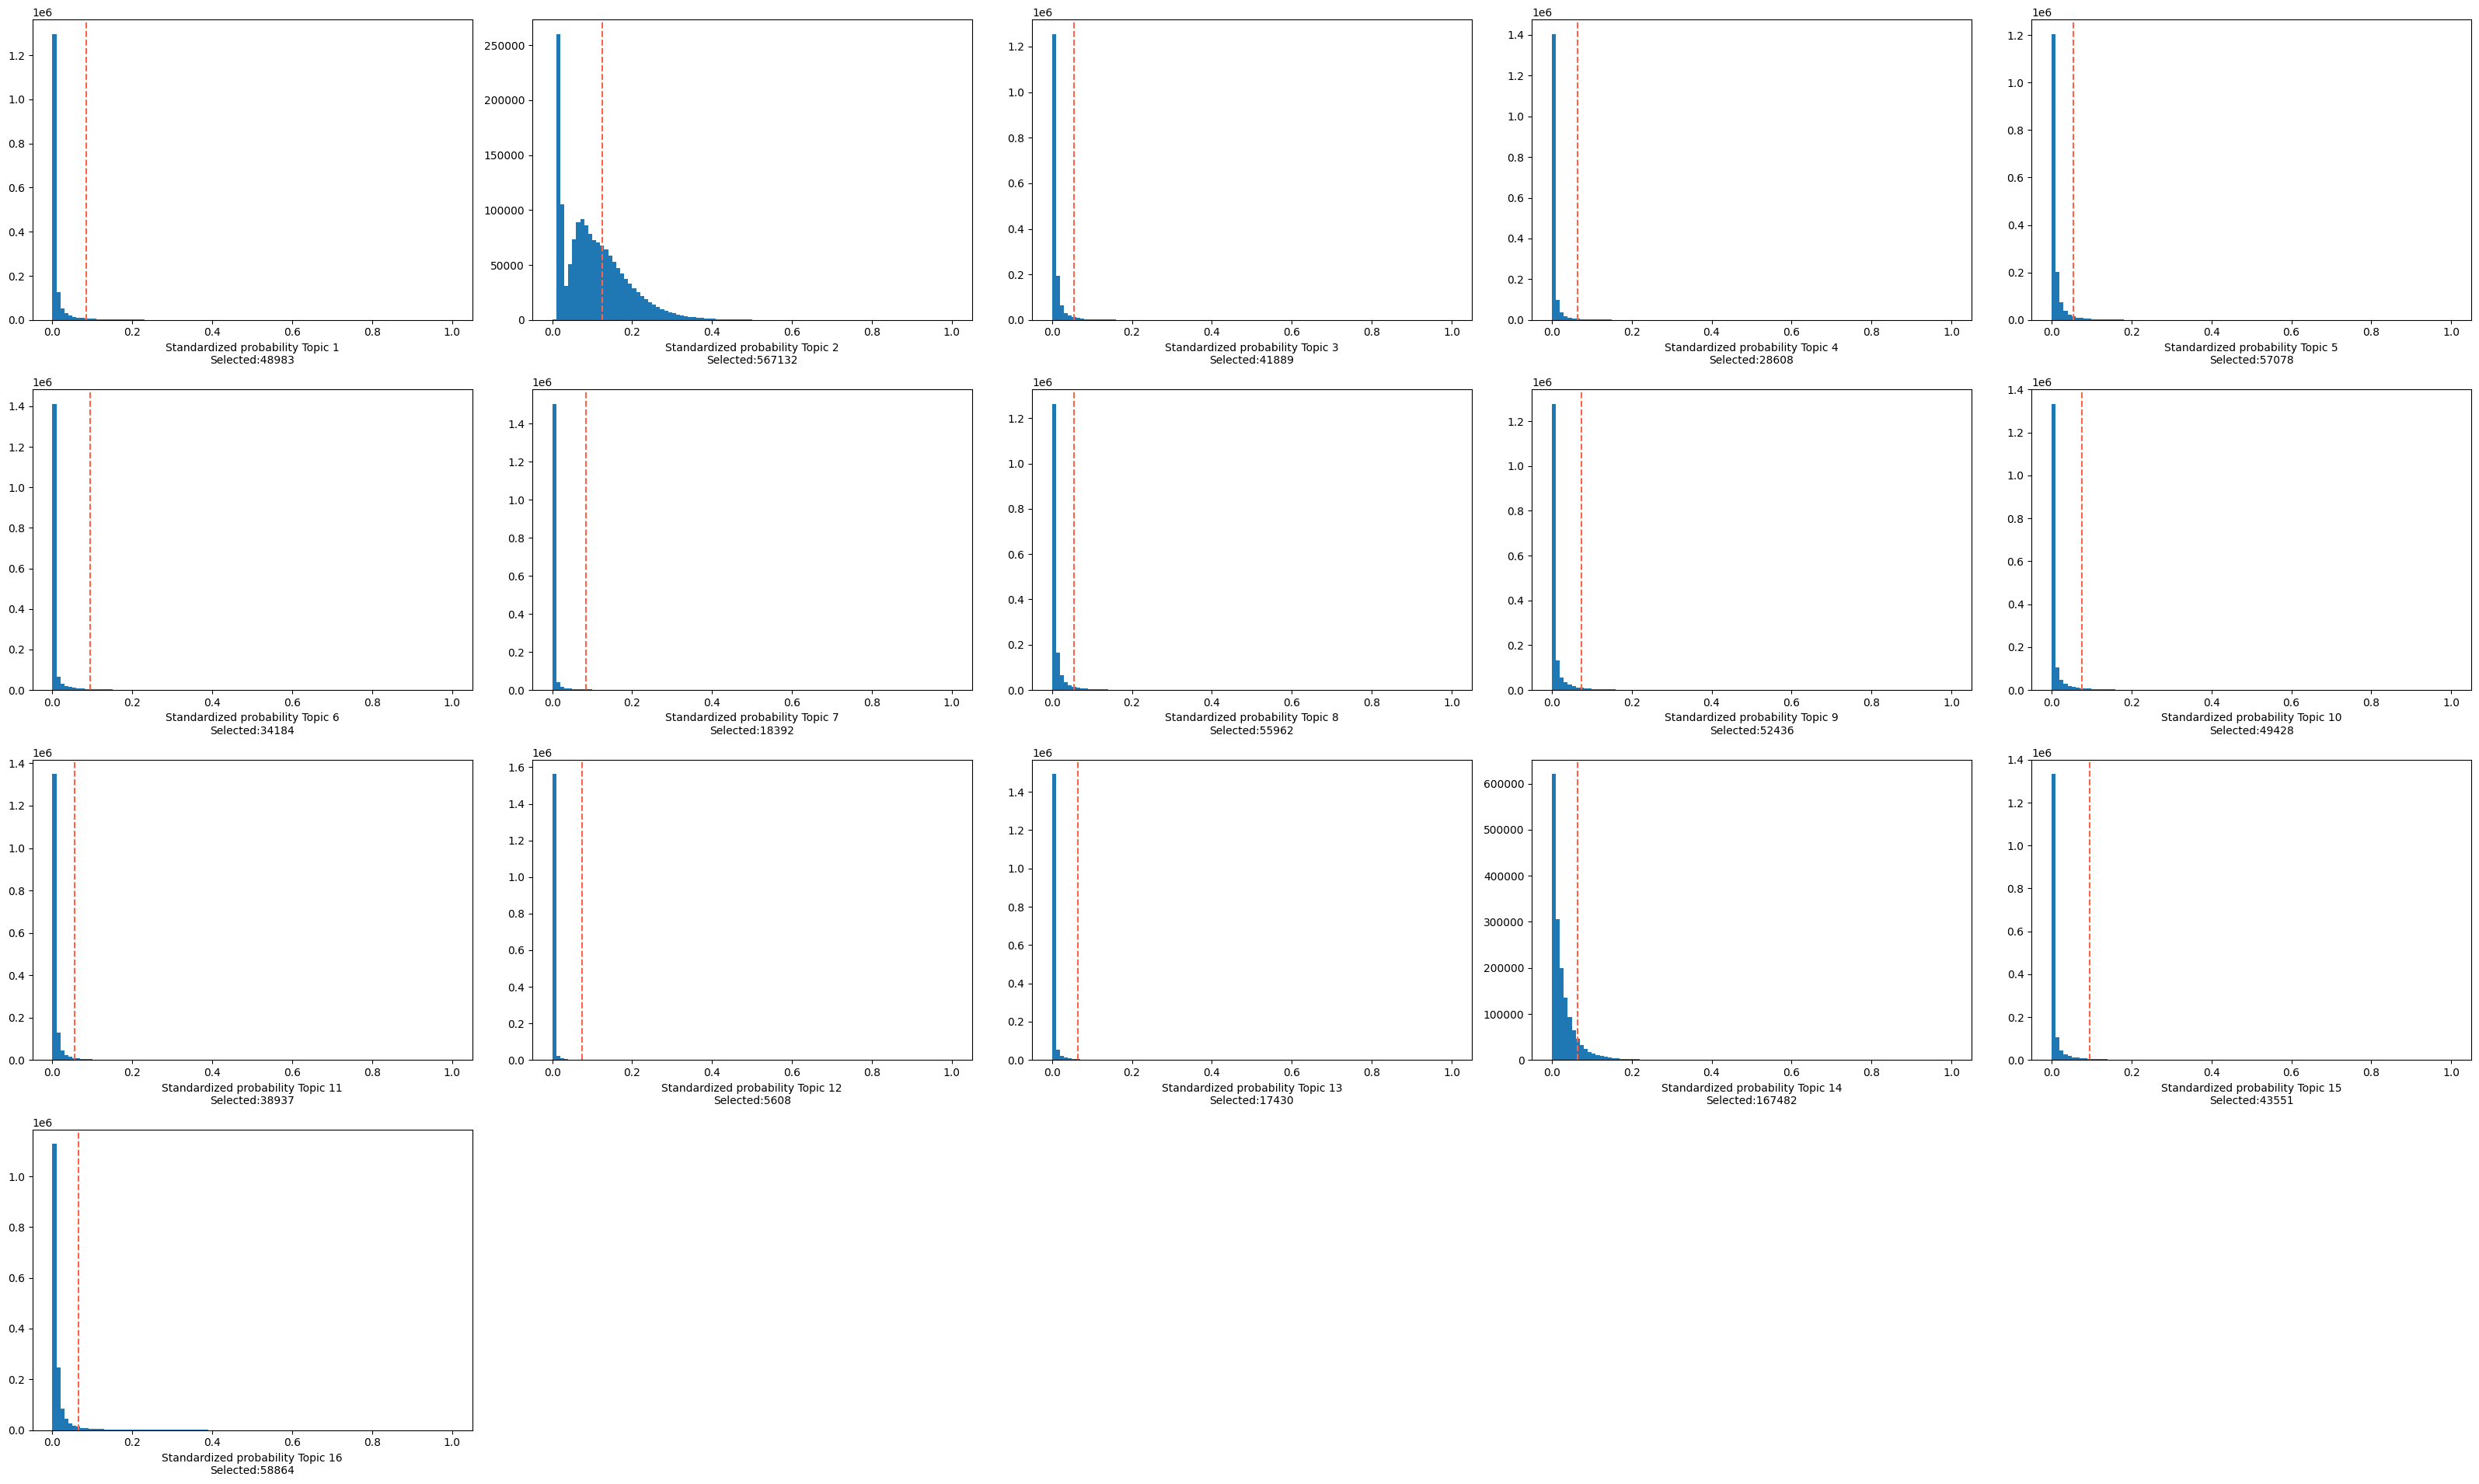

In [29]:
os.makedirs(os.path.join(save_dir, 'figures', 'topic_binarization'), exist_ok=True)

region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu', plot=True, num_columns=5,
                                         save = os.path.join(save_dir, 'figures', 'topic_binarization', 'region_topic_binarization_otsu'))

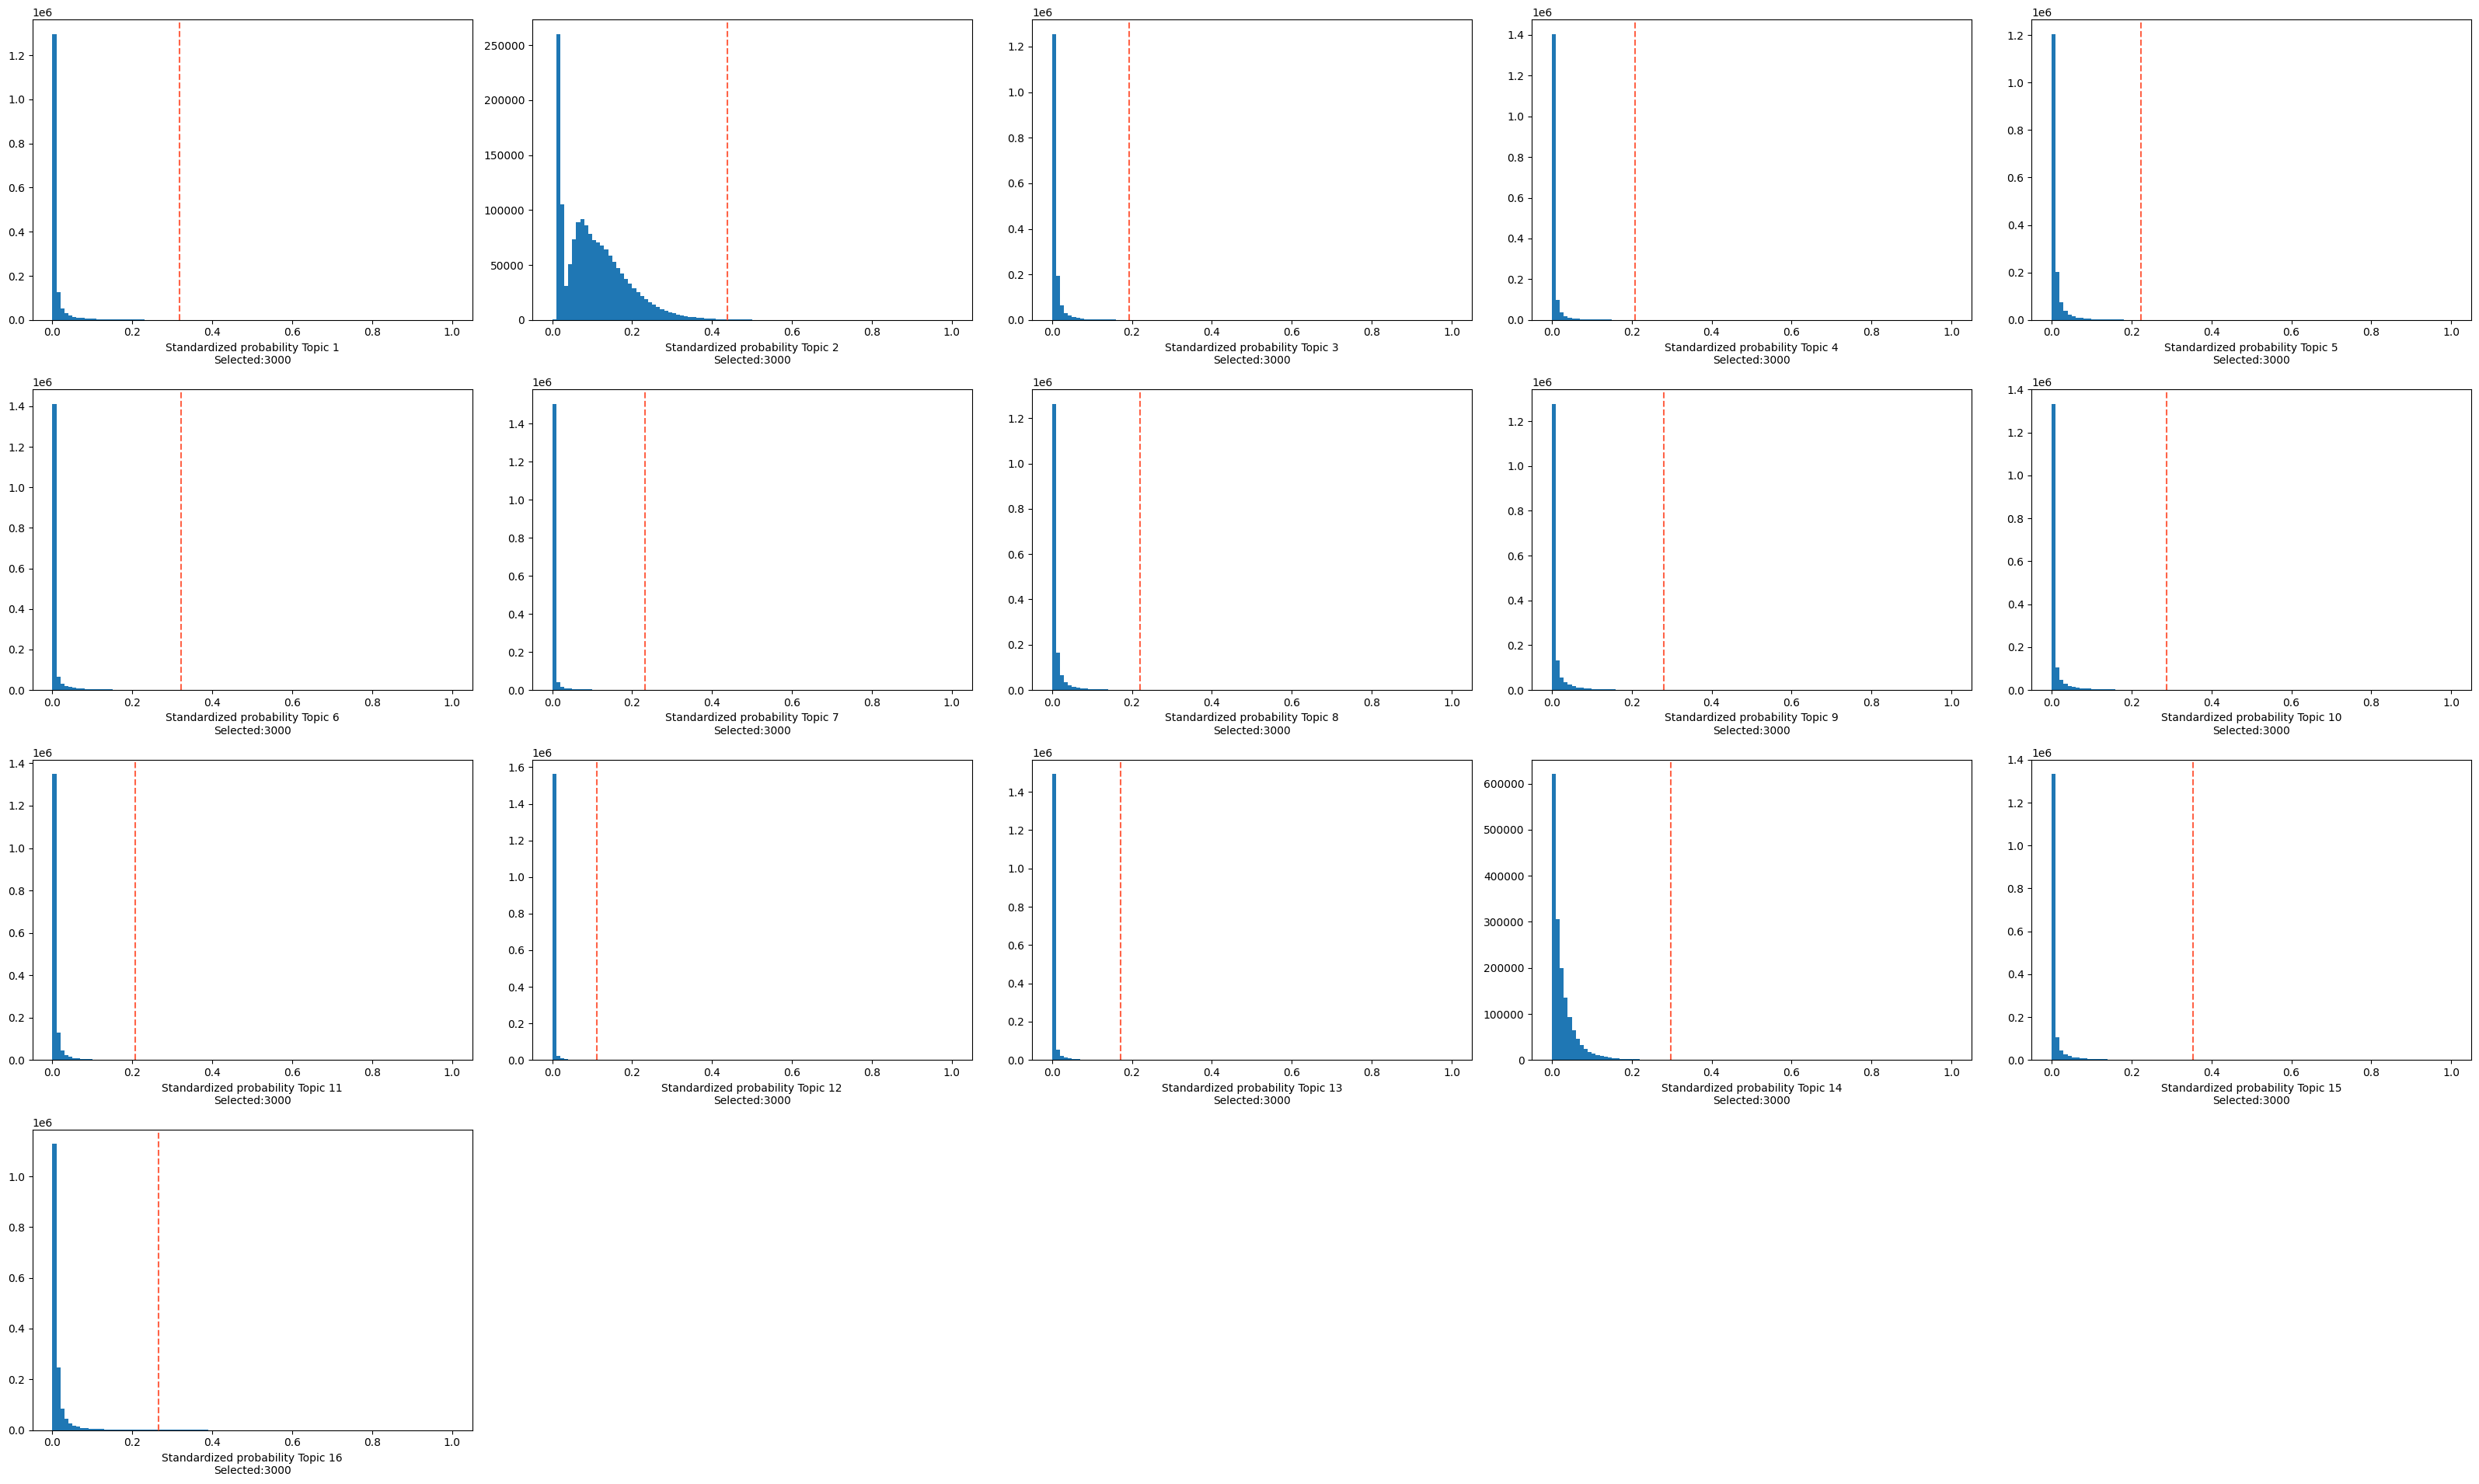

In [30]:
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3_000, plot=True, num_columns=5, 
                                          save = os.path.join(save_dir, f'figures', 'topic_binarization', 'region_topic_binarization_top3k'))

Similarly, we can now binarize the cell-topic distribions.

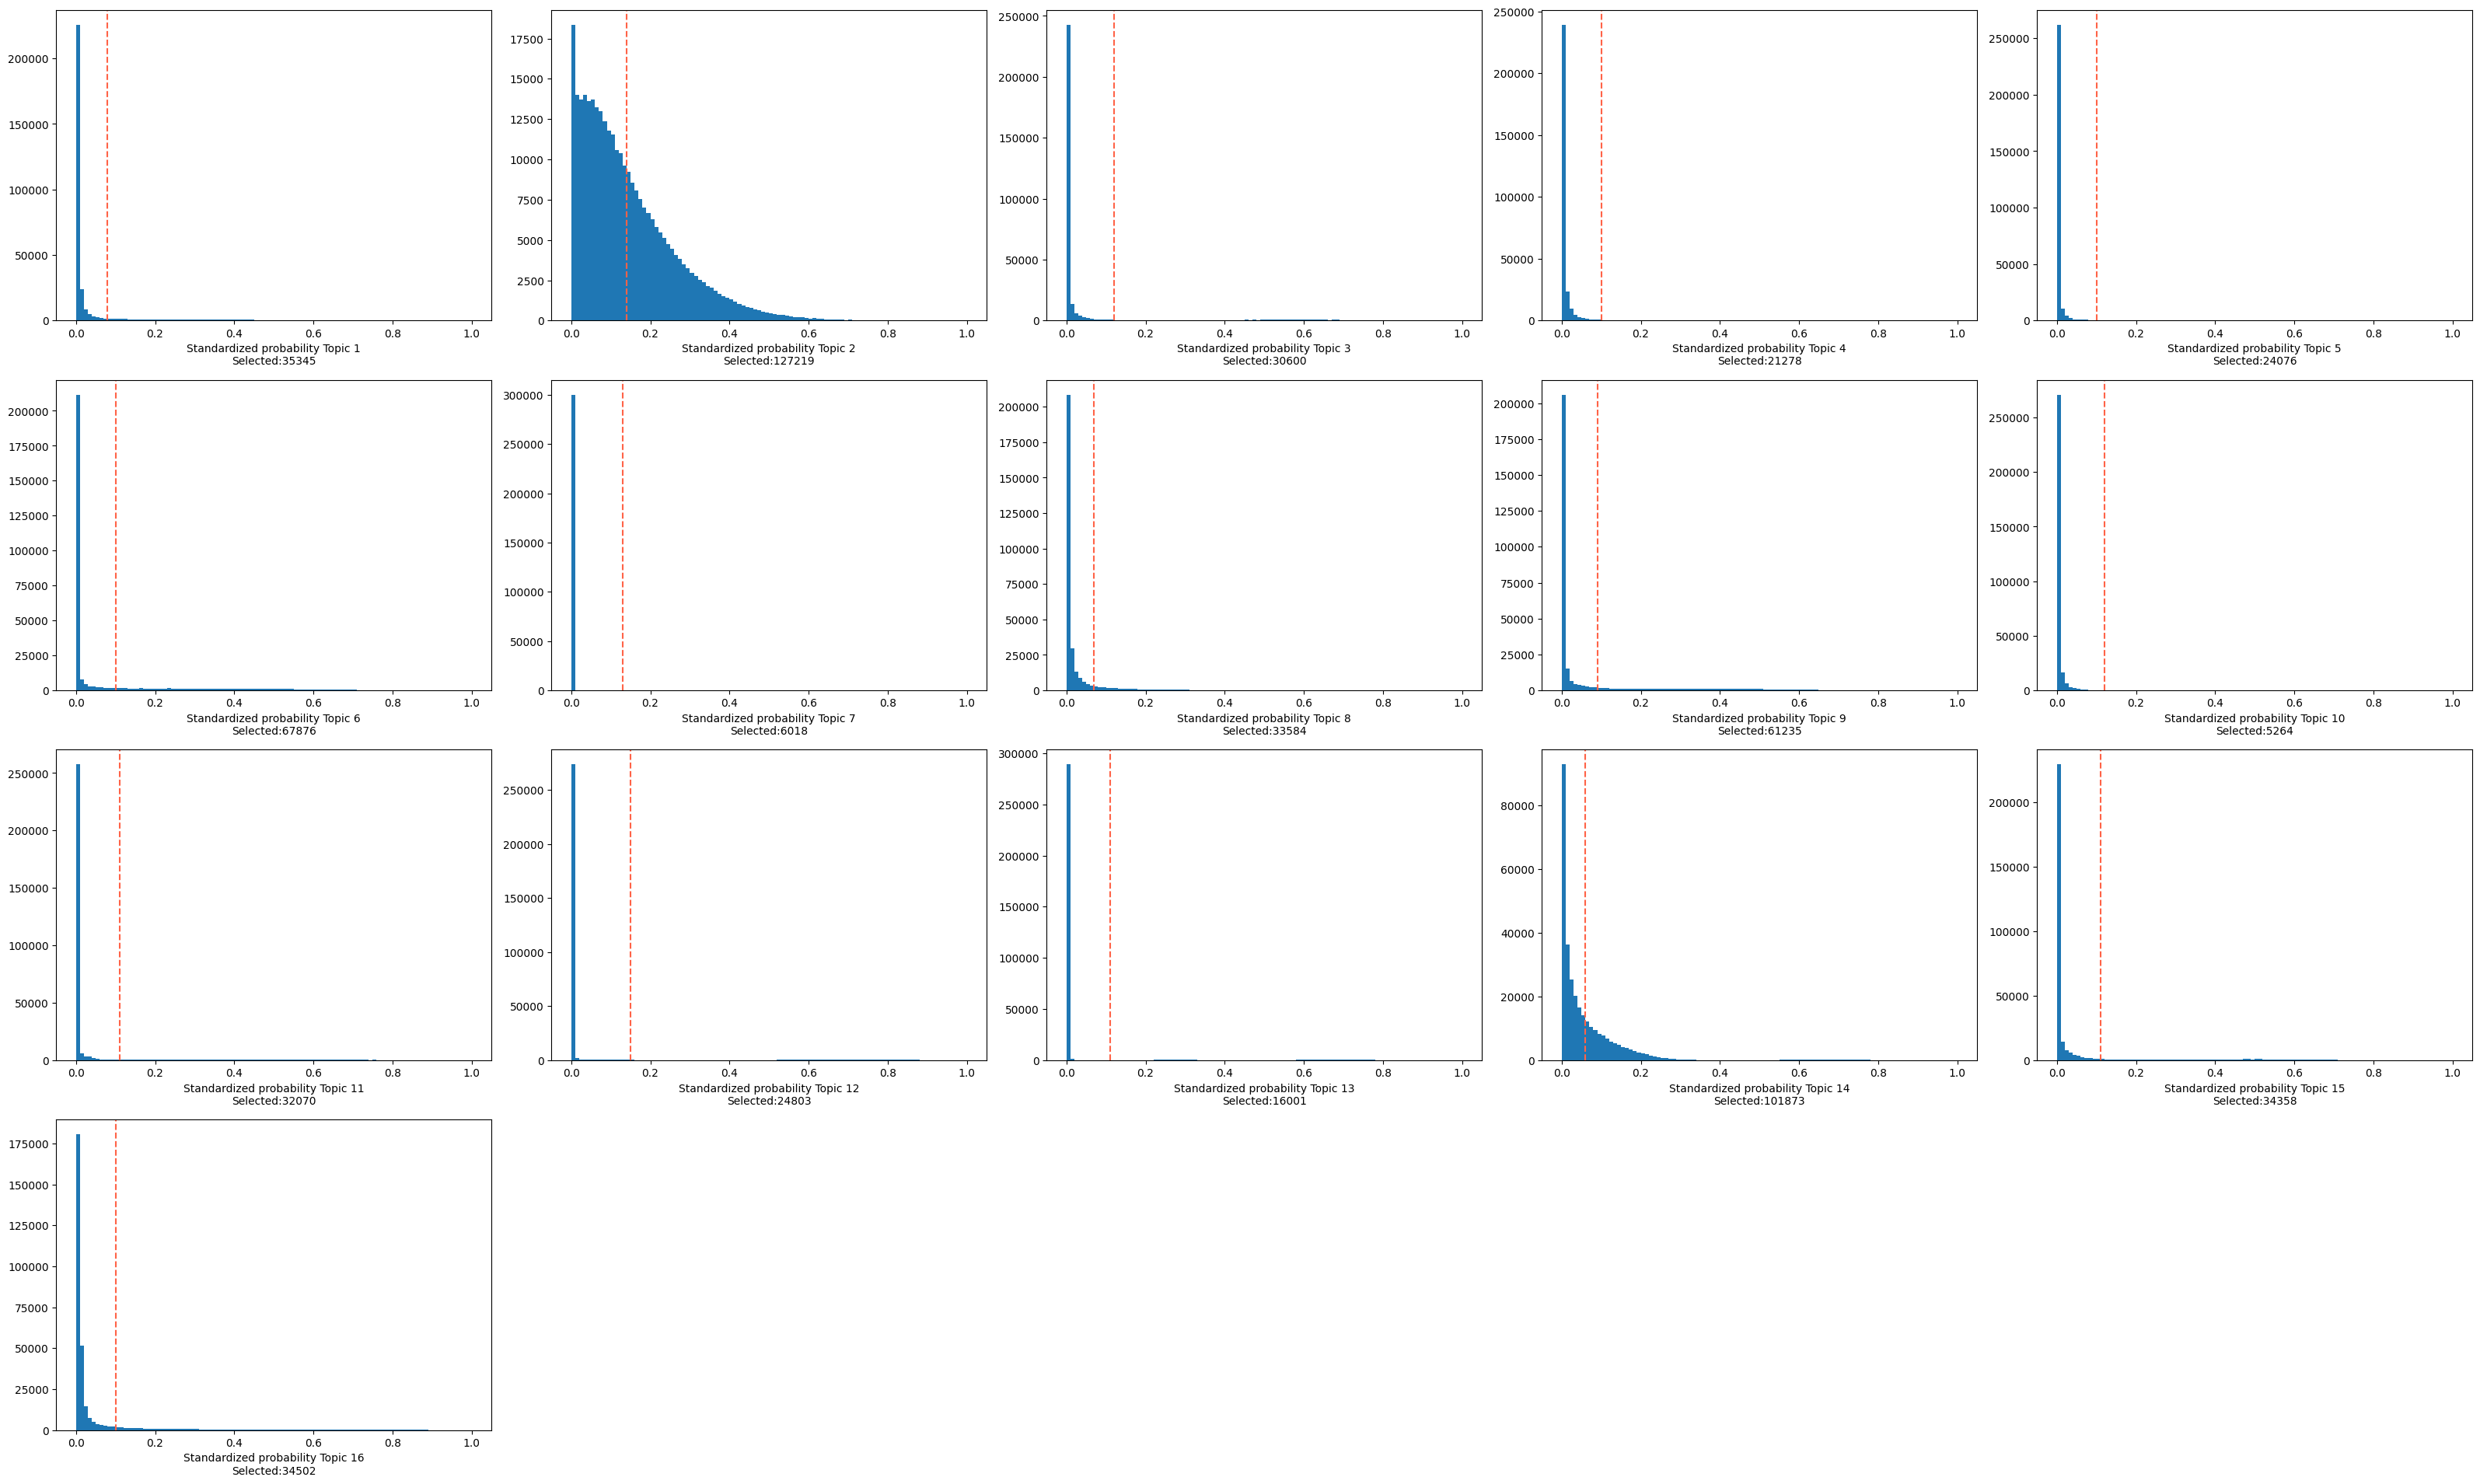

In [31]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100,
                                       save = os.path.join(save_dir, 'figures', 'topic_binarization', 'cell_topic_binarization_li'))

## **Topic QC and Annotation**

Following, we compute the topic quality control metrics. These include:

- **`Number of assignments`**

- **`Topic coherence (Mimno et al., 2011)`**: Measures to which extent high scoring regions in the topic are actually co-accessible in the original data. If it is low it indicates that the topic is rather random. The higher, the better is a topic.

- **`The marginal topic distribution`**: Indicates how much each topic contributes to the model. The higher, the better is a topic.

- **`The gini index`**: Value between 0 and 1, that indicates the specificity of topics (0: General, 1:Specific)

- If topics have been binarized, **`the number of regions/cells per topic`** will be added.

In [32]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [33]:
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [34]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

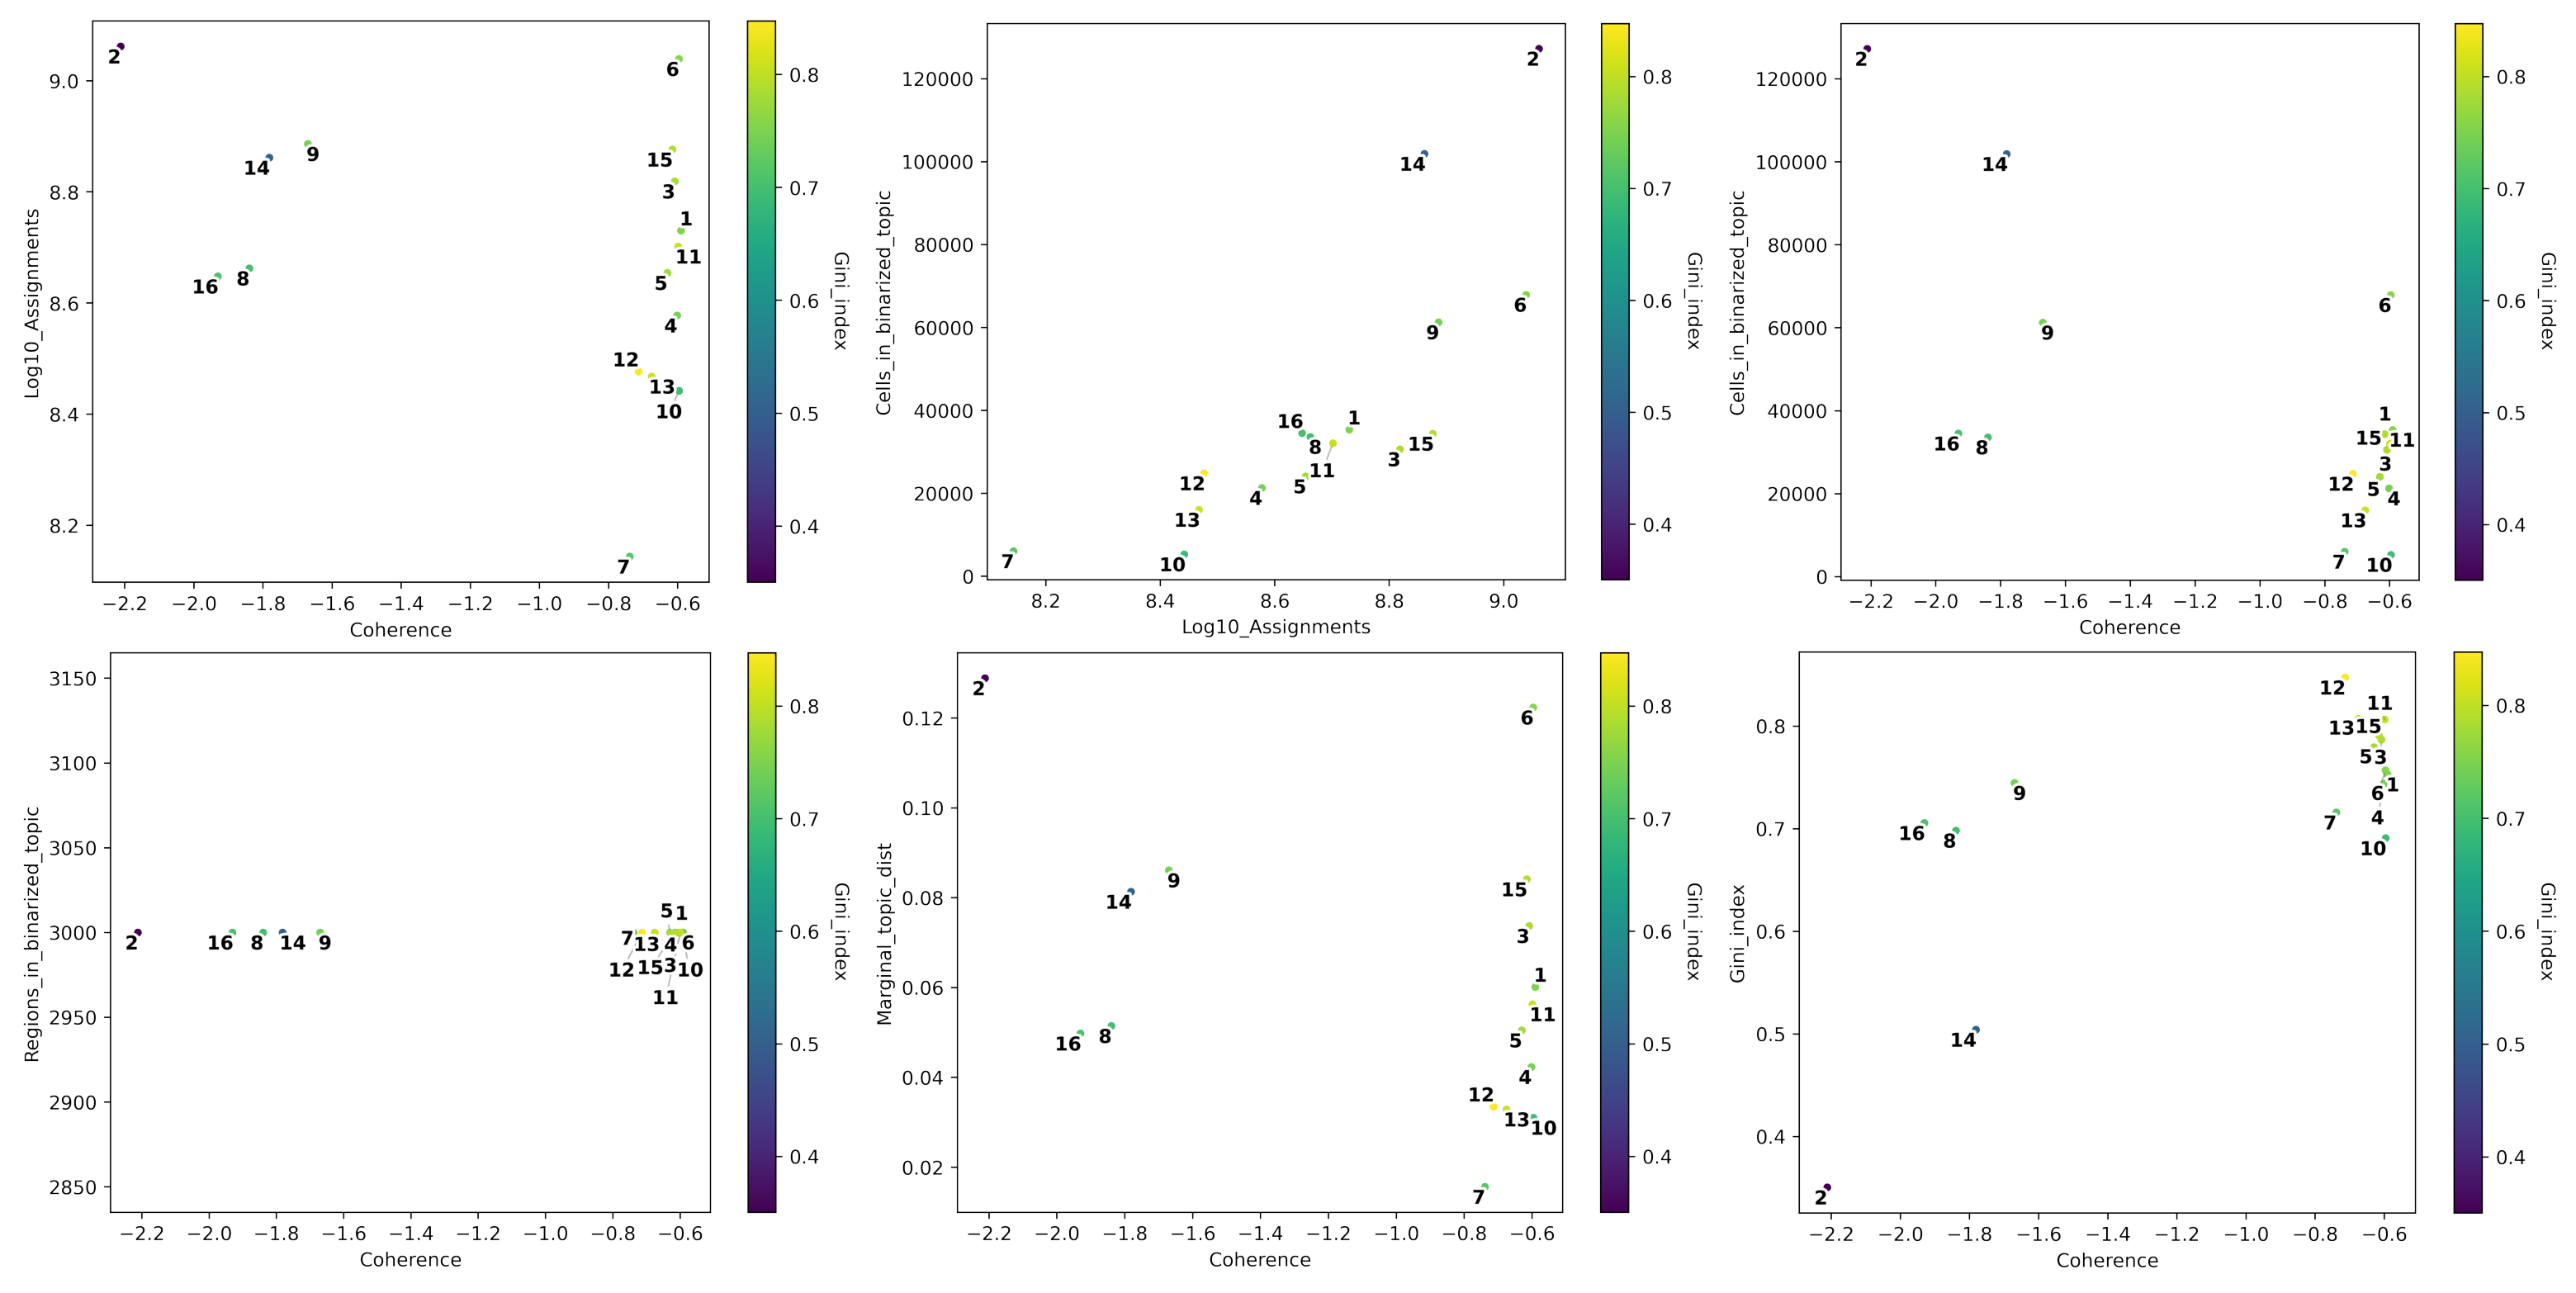

<Figure size 640x480 with 0 Axes>

In [35]:
os.makedirs(os.path.join(save_dir, 'figures', 'topic_qc'), exist_ok=True)

# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()
plt.savefig(fname = os.path.join(save_dir, 'figures', 'topic_qc', 'topic_qc.pdf'))

Next, we can automatically annotate topics, in this case by cell type. 

Here we calculate the proportion of cells in each group that are assigned to the binarized topic in comparison to the ratio in the whole data set.

`We will consider a topic as general if the difference between the ratio of cells in the whole data set in the binarized topic and the ratio of total cells in the assigned groups is above 0.2.` 

This indicates that the topic is general, and the propotion test may fail if the topic is enriched in both foreground (the group) and background (the whole data set); resulting in a big difference between the ratios.

In [36]:
topic_annot = topic_annotation(
                            cistopic_obj,
                            annot_var=cell_type_column,
                            binarized_cell_topic=binarized_cell_topic,
                            general_topic_thr = 0.2
                        )

/home/tadeoye/miniconda3/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [37]:
topic_annot

Subclass  \
Topic1            L5/6 NP, L6 CT, L4 IT, L6b, L5 ET, L5 IT   
Topic2   Lamp5, L4 IT, Endothelial, Pvalb, VLMC, Sst Ch...   
Topic3                              Pvalb, Chandelier, Sst   
Topic4                               Pvalb, Sst Chodl, Sst   
Topic5                  Lamp5, Lamp5 Lhx6, Pax6, Sncg, Vip   
Topic6                                      L2/3 IT, L6 IT   
Topic7                          Endothelial, Microglia-PVM   
Topic8                               L2/3 IT, L4 IT, L5 IT   
Topic9                                      L2/3 IT, L5 ET   
Topic10                                         L6 IT Car3   
Topic11                                    Pax6, Sncg, Vip   
Topic12                               Oligodendrocyte, OPC   
Topic13                               Astrocyte, VLMC, OPC   
Topic14  L5/6 NP, Lamp5 Lhx6, L6 CT, L4 IT, L6b, Pvalb,...   
Topic15                                       L4 IT, L5 IT   
Topic16        L6 CT, L6b, L5 ET, L6 IT Car3, L5 IT, L6 IT   

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1              0.115093                  0.215337       False  
Topic2              0.414259                  0.423276       False  
Topic3              0.099642                  0.143673       False  
Topic4              0.069287                  0.139463       False  
Topic5              0.078398                  0.156561       False  
Topic6              0.221022                  0.315848       False  
Topic7              0.019596                  0.019769       False  
Topic8              0.109359                  0.479101       False  
Topic9              0.199398                  0.292752       False  
Topic10             0.017141                  0.016887       False  
Topic11             0.104429                  0.110726       False  
Topic12             0.080765                  0.095705       False  
Topic13             0.052104                  0.052602       False  
Topic14             0.331726                  0.497027       False  
Topic15             0.111879                  0.187483       False  
Topic16             0.112348                  0.127574       False

In [38]:
if not os.path.exists(os.path.join(save_dir, 'topic_annotation')):
    os.makedirs(os.path.join(save_dir, 'topic_annotation'))

pickle.dump(topic_annot, open(os.path.join(save_dir, f'topic_annotation/{cell_type_column}_topic_annotation.pkl'), 'wb'))

## **Differentially Accessible Regions (DARs)**

In addition to working with regulatory topics, we also identify **`differentially accessible regions (DARs)`** between cell types.

### **Imputing Region Accessibility**

First, we impute the region accessibility by leveraging:
- Cell-topic probabilities
- Topic-region probabilities

To reduce very low probability values to 0, we employ a scale factor (default: 10^6).

### **Identifying Highly Variable Regions**

Next, we identify highly variable regions. While not mandatory, this step accelerates the hypothesis testing process for identifying DARs.

### **Finding Differentially Accessible Regions**

We can now identify differentially accessible regions between groups:

- By default, this function performs a Wilcoxon rank-sum test between each group using the specified variable and the rest.
- Alternatively, specific contrasts can be provided as a list with foreground and background groups.

Example contrast:
- Group 1 versus Groups 2 and 3
- Group 2 versus Groups 1 and 3

```python
contrast = [ 
            [['Group_1'], ['Group_2', 'Group_3']],
            [['Group_2'], ['Group_1', 'Group_3']]
        ]
```

In [38]:
from pycisTopic.diff_features import (
                                    impute_accessibility,
                                    normalize_scores,
                                    find_highly_variable_features,
                                    find_diff_features,
                                    CistopicImputedFeatures
                                )

2024-08-01 15:58:07,790 cisTopic     INFO     Imputing region accessibility
2024-08-01 15:58:07,792 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-08-01 15:58:54,545 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-08-01 15:59:39,893 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-08-01 16:00:24,779 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-08-01 16:01:08,677 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-08-01 16:01:57,342 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-08-01 16:02:42,216 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-08-01 16:03:27,956 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-08-01 16:04:12,470 cisTopic     INFO     Done!
2024-08-01 16:04:12,474 cisTopic     INFO     Normalizing imputed data
2024-08-01 16:

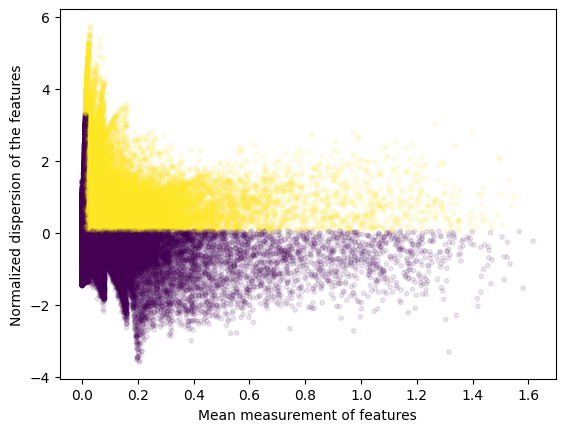

2024-08-01 16:12:24,518 cisTopic     INFO     Done!
There are 22578 variable regions in chunk 


2024-08-01 16:13:07,964	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 16:13:09,462 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 16:13:19,794 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 16:15:57,920 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 16:16:01,029 cisTopic     INFO     Astrocyte done!
2024-08-01 16:16:03,509 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 16:16:07,968 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 16:18:30,822 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 16:18:31,263 cisTopic     INFO     Chandelier done!
2024-08-01 16:18:33,825 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 16:18:38,334 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 16:21:01,520 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 16:21:01,980 cisTopic     INFO     Endothelial done!
2024-08-01 16:21:04,583 cisTopic     INFO     Subsetting d

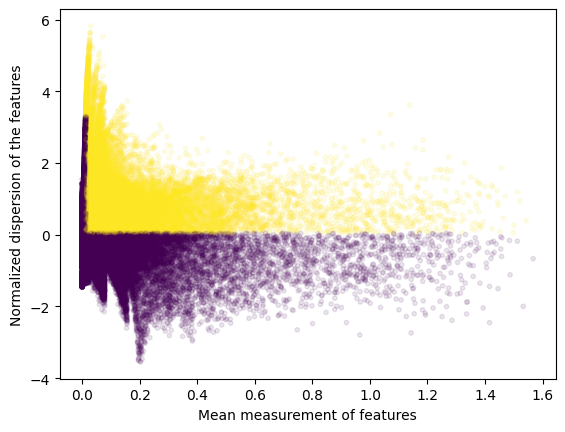

2024-08-01 17:29:01,087 cisTopic     INFO     Done!
There are 22457 variable regions in chunk 


2024-08-01 17:29:44,742	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 17:29:46,176 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 17:29:50,688 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 17:32:21,446 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 17:32:21,947 cisTopic     INFO     Astrocyte done!
2024-08-01 17:32:24,459 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 17:32:28,812 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 17:34:48,271 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 17:34:48,759 cisTopic     INFO     Chandelier done!
2024-08-01 17:34:51,257 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 17:34:55,748 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 17:37:16,024 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 17:37:16,517 cisTopic     INFO     Endothelial done!
2024-08-01 17:37:19,060 cisTopic     INFO     Subsetting d

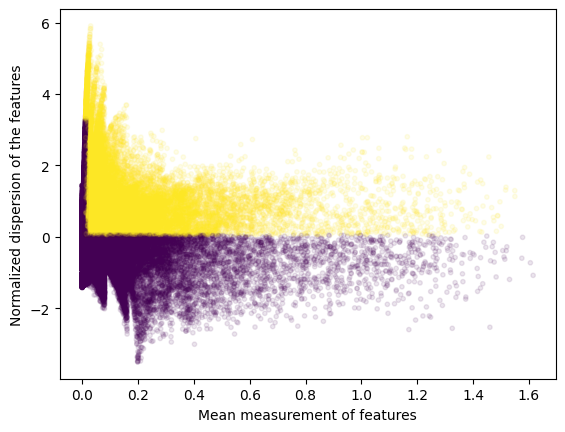

2024-08-01 18:44:19,488 cisTopic     INFO     Done!
There are 22356 variable regions in chunk 


2024-08-01 18:45:02,695	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 18:45:04,255 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 18:45:08,987 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 18:47:42,485 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 18:47:43,067 cisTopic     INFO     Astrocyte done!
2024-08-01 18:47:45,496 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 18:47:50,102 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 18:50:12,064 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 18:50:12,643 cisTopic     INFO     Chandelier done!
2024-08-01 18:50:15,094 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 18:50:19,690 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 18:52:43,495 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 18:52:44,155 cisTopic     INFO     Endothelial done!
2024-08-01 18:52:46,786 cisTopic     INFO     Subsetting d

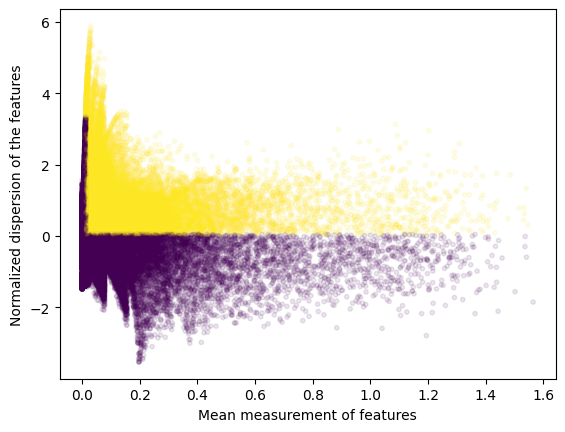

2024-08-01 19:59:55,376 cisTopic     INFO     Done!
There are 22533 variable regions in chunk 


2024-08-01 20:00:36,985	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 20:00:38,498 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 20:00:43,492 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 20:03:19,059 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 20:03:19,575 cisTopic     INFO     Astrocyte done!
2024-08-01 20:03:22,021 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 20:03:26,962 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 20:05:49,338 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 20:05:49,843 cisTopic     INFO     Chandelier done!
2024-08-01 20:05:52,343 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 20:05:57,083 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 20:08:20,748 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 20:08:21,225 cisTopic     INFO     Endothelial done!
2024-08-01 20:08:23,849 cisTopic     INFO     Subsetting d

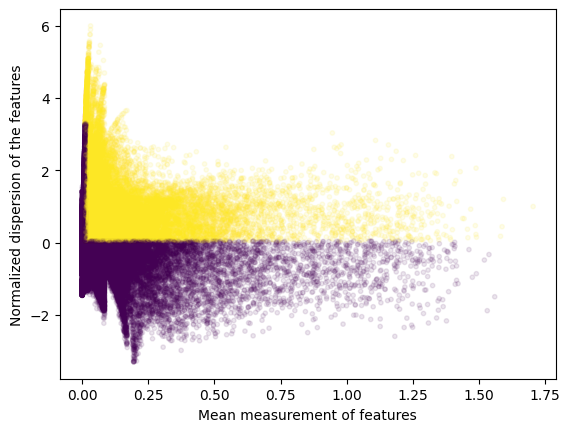

2024-08-01 21:15:38,851 cisTopic     INFO     Done!
There are 22522 variable regions in chunk 


2024-08-01 21:16:20,913	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 21:16:22,350 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 21:16:28,198 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 21:19:06,108 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 21:19:06,636 cisTopic     INFO     Astrocyte done!
2024-08-01 21:19:09,193 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 21:19:14,479 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 21:21:34,525 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 21:21:35,011 cisTopic     INFO     Chandelier done!
2024-08-01 21:21:37,624 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 21:21:42,950 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 21:24:03,458 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 21:24:03,962 cisTopic     INFO     Endothelial done!
2024-08-01 21:24:06,689 cisTopic     INFO     Subsetting d

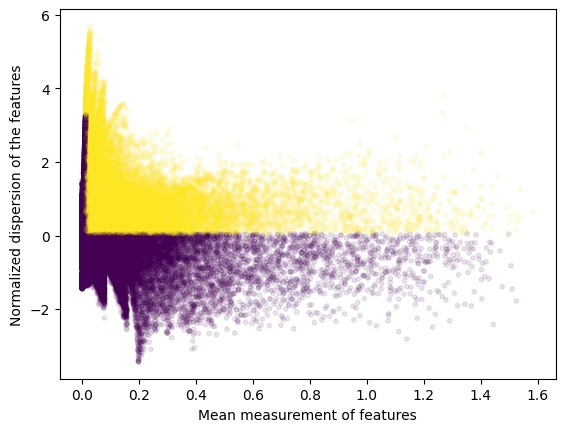

2024-08-01 22:31:35,125 cisTopic     INFO     Done!
There are 22729 variable regions in chunk 


2024-08-01 22:32:16,843	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 22:32:18,373 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 22:32:22,896 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 22:35:01,266 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 22:35:01,867 cisTopic     INFO     Astrocyte done!
2024-08-01 22:35:04,280 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 22:35:08,664 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 22:37:28,253 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 22:37:28,780 cisTopic     INFO     Chandelier done!
2024-08-01 22:37:31,533 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 22:37:35,922 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 22:39:57,131 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 22:39:57,695 cisTopic     INFO     Endothelial done!
2024-08-01 22:40:00,355 cisTopic     INFO     Subsetting d

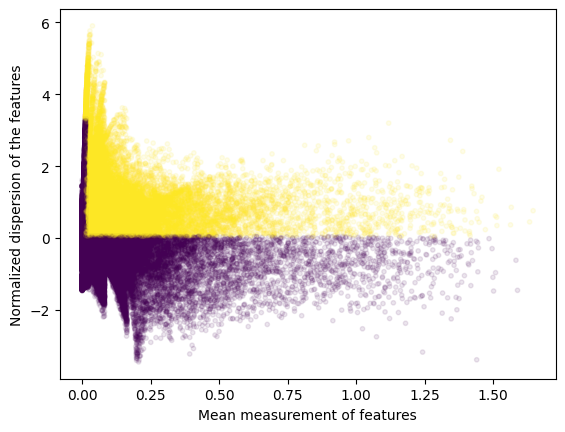

2024-08-01 23:46:45,410 cisTopic     INFO     Done!
There are 22609 variable regions in chunk 


2024-08-01 23:47:27,849	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-01 23:47:29,404 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-01 23:47:33,903 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-01 23:50:10,326 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-01 23:50:10,830 cisTopic     INFO     Astrocyte done!
2024-08-01 23:50:13,342 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-01 23:50:17,662 cisTopic     INFO     Computing p-value for Chandelier
2024-08-01 23:52:41,368 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-01 23:52:41,866 cisTopic     INFO     Chandelier done!
2024-08-01 23:52:44,382 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-01 23:52:49,038 cisTopic     INFO     Computing p-value for Endothelial
2024-08-01 23:55:13,416 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-01 23:55:13,960 cisTopic     INFO     Endothelial done!
2024-08-01 23:55:16,454 cisTopic     INFO     Subsetting d

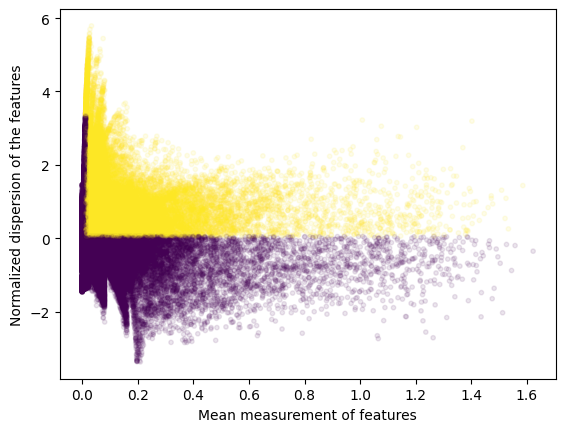

2024-08-02 01:07:14,062 cisTopic     INFO     Done!
There are 22385 variable regions in chunk 


2024-08-02 01:07:56,326	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-02 01:07:57,822 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-02 01:08:02,235 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-02 01:10:44,828 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-02 01:10:45,349 cisTopic     INFO     Astrocyte done!
2024-08-02 01:10:47,921 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-02 01:10:52,260 cisTopic     INFO     Computing p-value for Chandelier
2024-08-02 01:13:13,912 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-02 01:13:14,473 cisTopic     INFO     Chandelier done!
2024-08-02 01:13:17,078 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-02 01:13:21,452 cisTopic     INFO     Computing p-value for Endothelial
2024-08-02 01:15:44,511 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-02 01:15:45,023 cisTopic     INFO     Endothelial done!
2024-08-02 01:15:47,629 cisTopic     INFO     Subsetting d

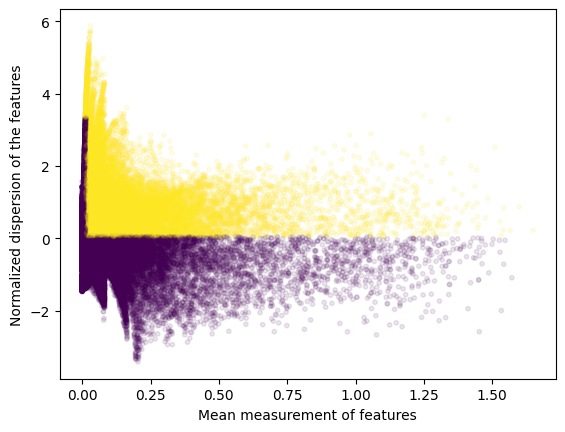

2024-08-02 02:23:19,431 cisTopic     INFO     Done!
There are 22352 variable regions in chunk 


2024-08-02 02:24:00,831	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-02 02:24:02,449 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-02 02:24:06,886 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-02 02:26:39,339 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-02 02:26:39,859 cisTopic     INFO     Astrocyte done!
2024-08-02 02:26:42,250 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-02 02:26:46,971 cisTopic     INFO     Computing p-value for Chandelier
2024-08-02 02:29:06,909 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-02 02:29:07,411 cisTopic     INFO     Chandelier done!
2024-08-02 02:29:09,991 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-02 02:29:14,589 cisTopic     INFO     Computing p-value for Endothelial
2024-08-02 02:31:36,878 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-02 02:31:37,358 cisTopic     INFO     Endothelial done!
2024-08-02 02:31:39,931 cisTopic     INFO     Subsetting d

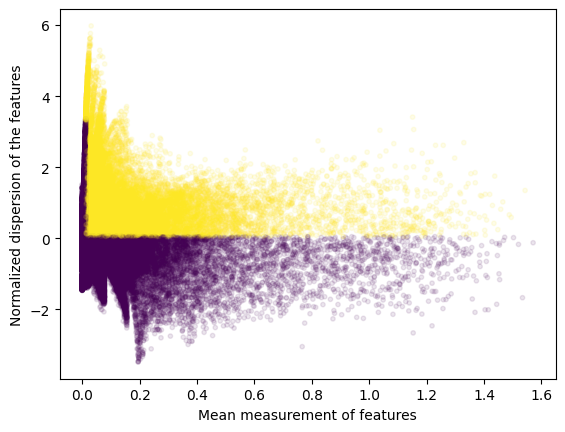

2024-08-02 03:39:04,047 cisTopic     INFO     Done!
There are 22628 variable regions in chunk 


2024-08-02 03:39:45,974	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-02 03:39:47,585 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-02 03:39:52,729 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-02 03:42:25,876 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-02 03:42:26,421 cisTopic     INFO     Astrocyte done!
2024-08-02 03:42:28,930 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-02 03:42:34,068 cisTopic     INFO     Computing p-value for Chandelier
2024-08-02 03:44:54,948 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-02 03:44:55,498 cisTopic     INFO     Chandelier done!
2024-08-02 03:44:57,959 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-02 03:45:02,993 cisTopic     INFO     Computing p-value for Endothelial
2024-08-02 03:47:25,141 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-02 03:47:25,695 cisTopic     INFO     Endothelial done!
2024-08-02 03:47:28,490 cisTopic     INFO     Subsetting d

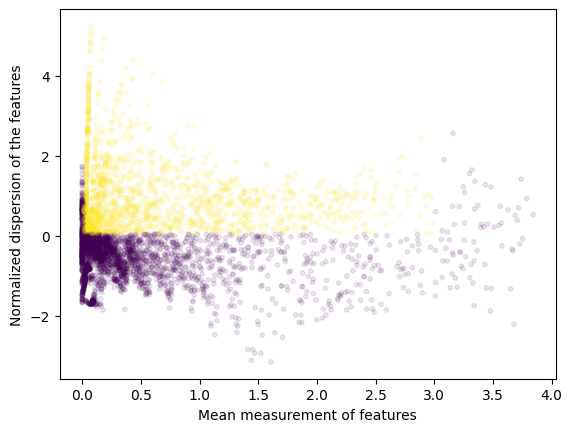

2024-08-02 04:41:50,675 cisTopic     INFO     Done!
There are 1946 variable regions in chunk 


2024-08-02 04:42:01,045	INFO worker.py:1724 -- Started a local Ray instance.


2024-08-02 04:42:02,600 cisTopic     INFO     Subsetting data for Astrocyte (10111 of 307100)
2024-08-02 04:42:03,138 cisTopic     INFO     Computing p-value for Astrocyte
2024-08-02 04:43:35,017 cisTopic     INFO     Computing log2FC for Astrocyte
2024-08-02 04:43:35,087 cisTopic     INFO     Astrocyte done!
2024-08-02 04:43:35,596 cisTopic     INFO     Subsetting data for Chandelier (1577 of 307100)
2024-08-02 04:43:36,100 cisTopic     INFO     Computing p-value for Chandelier
2024-08-02 04:45:02,615 cisTopic     INFO     Computing log2FC for Chandelier
2024-08-02 04:45:02,686 cisTopic     INFO     Chandelier done!
2024-08-02 04:45:03,269 cisTopic     INFO     Subsetting data for Endothelial (176 of 307100)
2024-08-02 04:45:03,820 cisTopic     INFO     Computing p-value for Endothelial
2024-08-02 04:46:31,599 cisTopic     INFO     Computing log2FC for Endothelial
2024-08-02 04:46:31,685 cisTopic     INFO     Endothelial done!
2024-08-02 04:46:32,236 cisTopic     INFO     Subsetting d

In [39]:
import gc

chunk_size = 160000

markers_chunk_dict = {}

for input_chunk_start in range(0, len(cistopic_obj.region_names), chunk_size):
    input_chunk_end = min(input_chunk_start + chunk_size, len(cistopic_obj.region_names))

    region_names_chunk = cistopic_obj.region_names[input_chunk_start:input_chunk_end]
    
    # Imputing Region Accessibility
    imputed_acc_obj = impute_accessibility(cistopic_obj, 
                                           selected_cells=None, 
                                           selected_regions=region_names_chunk, 
                                           scale_factor=10**6)
    
    normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, 
                                                  scale_factor=10**4)

    # Identifying Highly Variable Regions
    
    variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, 
                                                     plot = True, 
                                                     save=os.path.join(save_dir, 
                                                                     'figures', 
                                                                     f'highly_variable_regions_{input_chunk_start}_{input_chunk_end}.pdf'))
    del normalized_imputed_acc_obj
    
    gc.collect()

    print(f'There are {len(variable_regions)} variable regions in chunk ')

    markers_dict = find_diff_features(cistopic_obj, 
                                      imputed_acc_obj, 
                                      variable=cell_type_column, 
                                      var_features=variable_regions,
                                      contrasts = None,
                                      split_pattern = '-',
                                      adjpval_thr=0.05,
                                      log2fc_thr=np.log2(1.5),
                                      n_cpu=40,
                                      _temp_dir = os.path.join(tmp_dir, 'ray_spill')
                                    )
    markers_chunk_dict[f'{input_chunk_start}-{input_chunk_end}'] = markers_dict
    
    del imputed_acc_obj

Now let's merge the markers for each cell type across all region chunks

In [59]:
def merge_markers_dict_by_chunk(markers_chunk_dict):
    merged_dict = {}
    
    for cell_type in markers_chunk_dict['0-160000'].keys():
        if cell_type not in merged_dict:
            merged_dict[cell_type] = pd.DataFrame()

        for chunk in markers_chunk_dict.keys():
            df = markers_chunk_dict[chunk][cell_type]

            merged_dict[cell_type] = pd.concat([merged_dict[cell_type], df])
    
    return merged_dict

merged_markers = merge_markers_dict_by_chunk(markers_chunk_dict)

In [63]:
if not os.path.exists(os.path.join(save_dir, 'candidate_enhancers')):
    os.makedirs(os.path.join(save_dir, 'candidate_enhancers'))

pickle.dump(region_bin_topics_otsu, open(os.path.join(save_dir, f'candidate_enhancers/{cell_type_column}_region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(save_dir, f'candidate_enhancers/{cell_type_column}_region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(merged_markers, open(os.path.join(save_dir, f'candidate_enhancers/{cell_type_column}_markers_dict.pkl'), 'wb'))

Now, let's save the `cistopic_obj`

In [39]:
pickle.dump(cistopic_obj, open(os.path.join(save_dir, 'cistopic_objects/all_sample_cistopic.pkl'), 'wb')) 

We now completed all the mininal scATAC-seq preprocessing steps. 

In particular we:

1. Generated a set of **`consensus peaks`**.
2. Performed **`quality control steps`**, retaining only cell barcodes that passed QC metrics in both the scRNA-seq and scATAC-seq assays.
3. Conducted **`topic modeling`**.
4. **`Inferred candidate enhancer regions`** by binarizing the region-topic probabilities and differentially accessible regions (DARs) per cell type.

Next, we will perform **`motif enrichment analysis`** on these candidate enhancer regions using the Python package, [pycistarget](https://pycistarget.readthedocs.io/en/latest/). For this, a precomputed motif-score database is needed. A sample-specific database can be generated by scoring the consensus peaks with motifs, or a general pre-scored database can also be used. 

**`Here, we use a pre-scored database`**